# Cell 1 - Import & Konfigurasi Global

In [ ]:
# CELL 1 – IMPORT & KONFIGURASI GLOBAL

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Styling plot
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 5)

# Path data
DATA_DIR = Path(".")
PROCESSED_PATH = DATA_DIR / "processed_daily_wide.csv"

# Konfigurasi split
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Random generator global untuk semua model
RNG = np.random.default_rng(42)
np.random.seed(42)

# Cell 2 - Load Data & Daftar Komoditas

In [48]:
# CELL 2 – LOAD DATA WIDE & DAFTAR KOMODITAS

df = pd.read_csv(PROCESSED_PATH, parse_dates=["date"])
df = df.sort_values("date").set_index("date")

print("Shape data wide:", df.shape)
print("Tanggal awal:", df.index.min())
print("Tanggal akhir:", df.index.max())

commodities = df.columns.tolist()
print("Jumlah komoditas:", len(commodities))
print("Daftar komoditas:")
for c in commodities:
    print(" -", c)

Shape data wide: (457, 16)
Tanggal awal: 2024-02-01 00:00:00
Tanggal akhir: 2025-10-31 00:00:00
Jumlah komoditas: 16
Daftar komoditas:
 - Bawang Merah
 - Bawang Putih Honan
 - Beras Medium
 - Beras Premium
 - Cabai Merah Besar
 - Cabai Merah Keriting
 - Cabai Rawit Merah
 - Daging Ayam Ras
 - Daging Sapi Paha Belakang
 - Gula Pasir Curah
 - Kedelai Impor
 - Minyak Goreng Sawit Curah
 - Minyak Goreng Sawit Kemasan Premium
 - Minyakita
 - Telur Ayam Ras
 - Tepung Terigu


# Cell 3 - Utility: Split, Scaling, Window, Metrik

In [49]:
# CELL 3 – UTILITY FUNGSI: SPLIT, SCALING, WINDOW, METRICS

def train_val_test_split(n, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO):
    """
    Membagi index deret waktu menjadi train, val, test (berbasis posisi).
    """
    n_test = int(n * test_ratio)
    n_val = int(n * val_ratio)
    n_train = n - n_val - n_test
    idx = np.arange(n)
    return idx[:n_train], idx[n_train:n_train+n_val], idx[n_train+n_val:]


def scale_series_train_only(y):
    """
    MinMax scaling berdasarkan data TRAIN saja.
    Mengembalikan y_scaled (float) dan scaler dict {min, max}.
    """
    y = np.asarray(y, dtype=float)
    y_min, y_max = y.min(), y.max()
    if y_max == y_min:
        # seri konstan → scaling-nya jadi nol semua
        return np.zeros_like(y), {"min": y_min, "max": y_max}
    return (y - y_min) / (y_max - y_min), {"min": y_min, "max": y_max}


def inverse_scale(y_scaled, scaler):
    """
    Membalik scaling MinMax ke skala harga asli.
    """
    y_min, y_max = scaler["min"], scaler["max"]
    if y_max == y_min:
        return np.full_like(y_scaled, y_min, dtype=float)
    return y_scaled * (y_max - y_min) + y_min


def make_supervised(y, window):
    """
    Membentuk pasangan (X, y_target) dari seri y.
    X shape: (n_samples, window, 1), y: (n_samples,)
    """
    y = np.asarray(y, dtype=float)
    X, Y = [], []
    for i in range(window, len(y)):
        X.append(y[i-window:i])
        Y.append(y[i])
    X = np.array(X)[:, :, None]  # tambah dimensi fitur
    Y = np.array(Y)
    return X, Y


def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def mae(y_true, y_pred):
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)))


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2))

# Cell 4 - Model ARIMA

In [ ]:
# CELL 4 – ARIMA FROM SCRATCH (ARIMA(p, d, D, s=5))

def _diff_series(y, d=1, D=0, s=5):
    x = np.asarray(y, dtype=float).copy()
    for _ in range(d):
        x = np.diff(x, n=1)
    for _ in range(D):
        x = x[s:] - x[:-s]
    return x

def _ols_ar_fit(y, p):
    """
    Fit model AR(p) dengan OLS pada seri y (yang sudah didifferencing).
    """
    if p == 0:
        c = float(np.mean(y)) if len(y) > 0 else 0.0
        return c, np.zeros(0)
    Y = y[p:]
    X = np.column_stack([y[p-k-1:-k-1] for k in range(p)])
    X = np.column_stack([np.ones(len(X)), X])  # intercept
    beta, *_ = np.linalg.lstsq(X, Y, rcond=None)
    c = float(beta[0]); phi = beta[1:]
    return c, phi

def _ar_forecast(y, c, phi, h):
    """
    Forecast AR(p) h langkah ke depan dari seri y.
    """
    p = len(phi)
    buf = list(y[-p:]) if p > 0 else []
    out = []
    for _ in range(h):
        if p == 0:
            yhat = c
        else:
            yhat = c + float(np.dot(phi, buf[::-1]))
            buf = (buf + [yhat])[-p:]
        out.append(yhat)
    return np.array(out)

def arima_pd0_predict(y_hist, horizon, p=0, d=1, D=1, s=5):
    """
    ARIMA(p, d, D) sederhana:
    - differencing non-musiman d kali
    - differencing musiman D kali dengan periode s
    - fit AR(p) di domain differenced
    - forecast differenced, kemudian rekonstruksi ke level.
    """
    y_hist = np.asarray(y_hist, dtype=float)
    y_diff = _diff_series(y_hist, d=d, D=D, s=s)
    c, phi = _ols_ar_fit(y_diff, p=p)
    y_diff_fc = _ar_forecast(y_diff, c, phi, h=horizon)

    # reconstruct ke level
    y_level = y_hist.copy()
    for step in range(horizon):
        incr = y_diff_fc[step]
        y_next = y_level[-1] + incr
        y_level = np.append(y_level, y_next)
    return y_level[-horizon:]

def fit_arima_for_series(y_train, y_val, pdD_grid):
    """
    Grid search sederhana ARIMA:
    - pdD_grid: list (p, d, D)
    Mengembalikan konfigurasi terbaik berdasarkan MAPE validation.
    """
    best_cfg = None
    best_mape_val = np.inf

    for (p, d, D) in pdD_grid:
        try:
            y_val_pred = arima_pd0_predict(y_train, len(y_val), p=p, d=d, D=D, s=5)
            score = mape(y_val, y_val_pred)
            if score < best_mape_val:
                best_mape_val = score
                best_cfg = (p, d, D)
        except Exception:
            continue

    return best_cfg, best_mape_val

# Cell 5 - Model LSTM

In [51]:
# CELL 5 – LSTM1D FROM SCRATCH

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


class LSTM1D:
    """
    LSTM 1D sederhana:
    - Hidden size h
    - Input satu dimensi (harga yang sudah diskalakan)
    - Output 1 nilai (prediksi harga berikutnya dalam skala yang sama).
    """
    def __init__(self, hidden=32, lr=0.003, clip=1.0, rng=None):
        self.h = hidden
        self.lr = lr
        self.clip = clip
        self.rng = rng or RNG
        k = 1/np.sqrt(hidden)

        # bobot gate (hidden + input) -> hidden
        self.Wf = self.rng.uniform(-k, k, (hidden, hidden+1))
        self.Wi = self.rng.uniform(-k, k, (hidden, hidden+1))
        self.Wo = self.rng.uniform(-k, k, (hidden, hidden+1))
        self.Wg = self.rng.uniform(-k, k, (hidden, hidden+1))
        # bobot output (hidden -> 1)
        self.Wy = self.rng.uniform(-k, k, (1, hidden))

    def _concat(self, h_prev, x_t):
        # menggabungkan h_prev (h,) dan x_t (scalar) menjadi (h+1,)
        return np.concatenate([h_prev, np.atleast_1d(x_t)], axis=0)

    def forward(self, x_seq):
        """
        Forward untuk satu sequence:
        x_seq shape: (T,)
        """
        T = len(x_seq); h = self.h
        hs = np.zeros((T, h))
        cs = np.zeros((T, h))
        h_prev = np.zeros(h)
        c_prev = np.zeros(h)
        cache = []

        for t in range(T):
            z = self._concat(h_prev, x_seq[t])
            f = sigmoid(self.Wf @ z)
            i = sigmoid(self.Wi @ z)
            o = sigmoid(self.Wo @ z)
            g = tanh(   self.Wg @ z)
            c_t = f*c_prev + i*g
            h_t = o * tanh(c_t)

            hs[t] = h_t
            cs[t] = c_t
            cache.append((z,f,i,o,g,h_prev,c_prev,c_t,h_t))
            h_prev, c_prev = h_t, c_t

        yhat = float(self.Wy @ hs[-1])
        return yhat, (hs, cs, cache)

    def backward(self, x_seq, target, yhat, cache_pack):
        """
        Backprop sederhana untuk 1 sequence.
        """
        hs, cs, cache = cache_pack
        T = len(x_seq); h = self.h
        dy = (yhat - target)

        dWy = dy * hs[-1].reshape(1,-1)
        dh_next = dy * self.Wy.T.ravel()
        dc_next = np.zeros(h)

        dWf = np.zeros_like(self.Wf)
        dWi = np.zeros_like(self.Wi)
        dWo = np.zeros_like(self.Wo)
        dWg = np.zeros_like(self.Wg)

        for t in reversed(range(T)):
            z,f,i,o,g,h_prev,c_prev,c_t,h_t = cache[t]

            do = dh_next * tanh(c_t) * o*(1-o)
            dc = dh_next * o*(1 - tanh(c_t)**2) + dc_next
            df = dc * c_prev * f*(1-f)
            di = dc * g * i*(1-i)
            dg = dc * i * (1 - g**2)

            dWf += np.outer(df, z)
            dWi += np.outer(di, z)
            dWo += np.outer(do, z)
            dWg += np.outer(dg, z)

            dz  = (self.Wf.T@df + self.Wi.T@di + self.Wo.T@do + self.Wg.T@dg)
            dh_prev = dz[:h]
            dc_prev = dc * f

            dh_next = dh_prev
            dc_next = dc_prev

        # clipping grad
        for G in (dWf,dWi,dWo,dWg,dWy):
            np.clip(G, -self.clip, self.clip, out=G)

        self.Wf -= self.lr*dWf
        self.Wi -= self.lr*dWi
        self.Wo -= self.lr*dWo
        self.Wg -= self.lr*dWg
        self.Wy -= self.lr*dWy

    def fit_one(self, x_seq, y_target):
        """
        Latih model pada satu sequence (window) dan satu target.
        """
        yhat, cache = self.forward(x_seq)
        self.backward(x_seq, y_target, yhat, cache)
        loss = float((yhat - y_target)**2)
        return loss, yhat

# Cell 6 - Model GRU

In [52]:
# CELL 6 – GRU1D FROM SCRATCH

class GRU1D:
    """
    GRU 1D sederhana:
    - Hidden size h
    - Input 1 dimensi (harga ter-scaling)
    - Output 1 nilai.
    """
    def __init__(self, hidden=32, lr=0.003, clip=1.0, rng=None):
        self.h = hidden
        self.lr = lr
        self.clip = clip
        self.rng = rng or RNG
        k = 1/np.sqrt(hidden)
        self.Wz = self.rng.uniform(-k, k, (hidden, hidden+1))
        self.Wr = self.rng.uniform(-k, k, (hidden, hidden+1))
        self.Wh = self.rng.uniform(-k, k, (hidden, hidden+1))
        self.Wy = self.rng.uniform(-k, k, (1, hidden))

    def _concat(self, h_prev, x_t):
        return np.concatenate([h_prev, np.atleast_1d(x_t)], axis=0)

    def forward(self, x_seq):
        """
        Forward 1 sequence x_seq shape (T,)
        """
        T = len(x_seq); h = self.h
        hs = np.zeros((T, h))
        h_prev = np.zeros(h)
        cache = []

        for t in range(T):
            z_in = self._concat(h_prev, x_seq[t])
            zt = sigmoid(self.Wz @ z_in)
            rt = sigmoid(self.Wr @ z_in)

            h_in = self._concat(rt * h_prev, x_seq[t])
            h_tilde = tanh(self.Wh @ h_in)

            h_t = (1 - zt) * h_prev + zt * h_tilde
            hs[t] = h_t
            cache.append((z_in, h_in, zt, rt, h_tilde, h_prev))
            h_prev = h_t

        yhat = float(self.Wy @ hs[-1])
        return yhat, (hs, cache)

    def backward(self, x_seq, target, yhat, cache_pack):
        """
        Backprop sederhana (tidak 100% derivasi paper, tapi cukup untuk belajar).
        """
        hs, cache = cache_pack
        T = len(x_seq); h = self.h
        dy = (yhat - target)

        dWy = dy * hs[-1].reshape(1, -1)
        dh_next = dy * self.Wy.T.ravel()

        dWz = np.zeros_like(self.Wz)
        dWr = np.zeros_like(self.Wr)
        dWh = np.zeros_like(self.Wh)

        for t in reversed(range(T)):
            z_in, h_in, zt, rt, h_tilde, h_prev = cache[t]

            dh = dh_next

            dh_tilde = dh * zt
            dzt = dh * (h_tilde - h_prev)
            dh_prev_part = dh * (1 - zt)

            # dh_in = (1 - h_tilde**2) * (self.Wh.T @ dh_tilde)
            # dWh += np.outer(dh_tilde, h_in)

            dh_in = self.Wh.T @ ((1 - h_tilde**2) * dh_tilde)
            dWh += np.outer(dh_tilde, h_in)

            dh_prev_from_rt = dh_in[:h] * rt
            drt = (dh_in[:h] * h_prev) * rt * (1-rt)

            dWz += np.outer(dzt, z_in)
            dWr += np.outer(drt, z_in)

            dh_prev = dh_prev_part + dh_prev_from_rt
            dh_next = dh_prev

        for G in (dWz, dWr, dWh, dWy):
            np.clip(G, -self.clip, self.clip, out=G)

        self.Wz -= self.lr * dWz
        self.Wr -= self.lr * dWr
        self.Wh -= self.lr * dWh
        self.Wy -= self.lr * dWy

    def fit_one(self, x_seq, y_target):
        yhat, cache = self.forward(x_seq)
        self.backward(x_seq, y_target, yhat, cache)
        loss = float((yhat - y_target)**2)
        return loss, yhat

# Cell 7 - EarlyStopping + Wrapper Fit LSTM/GRU + Konfigurasi

In [53]:
# CELL 7 – EARLY STOPPING & WRAPPER LSTM/GRU + KONFIGURASI

class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.best_loss = np.inf
        self.counter = 0
    
    def step(self, loss):
        if loss < self.best_loss - 1e-6:
            self.best_loss = loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


# Kelompok komoditas (boleh disesuaikan)
STABLE = [
    "Beras Medium", "Beras Premium", "Minyak Goreng Kemasan Premium",
    "Minyakita", "Tepung Terigu", "Daging Sapi Paha Belakang"
]

MODERATE = [
    "Telur Ayam Ras", "Gula Pasir Curah", "Kedelai Impor",
    "Minyak Goreng Curah", "Daging Ayam Ras"
]

VOLATILE = [
    "Bawang Merah", "Bawang Putih Honan",
    "Cabai Merah Besar", "Cabai Merah Keriting", "Cabai Rawit Merah"
]

WINDOW_GRID = {
    "stable":   [7, 10, 14],
    "moderate": [14, 21],
    "volatile": [21, 30]
}

UNITS_GRID = [16, 32]
EPOCHS_MAX = 50
EARLY_STOP_PATIENCE = 8
LR = 0.01


def get_volatility_group(name):
    if name in STABLE:
        return "stable"
    elif name in MODERATE:
        return "moderate"
    else:
        return "volatile"


def fit_lstm_for_series(y_train_scaled, y_val_scaled, window_grid, units_grid,
                        epochs_max=EPOCHS_MAX, lr=LR, patience=EARLY_STOP_PATIENCE):
    best_cfg = None
    best_mape_val = np.inf
    best_model = None

    for w in window_grid:
        X_tr, Y_tr = make_supervised(y_train_scaled, w)
        X_va, Y_va = make_supervised(np.concatenate([y_train_scaled[-w:], y_val_scaled]), w)

        for units in units_grid:
            model = LSTM1D(hidden=units, lr=lr, clip=1.0)
            es = EarlyStopping(patience=patience)

            for epoch in range(epochs_max):
                train_losses = []
                for i in range(len(Y_tr)):
                    x_seq = X_tr[i,:,0]
                    loss, _ = model.fit_one(x_seq, Y_tr[i])
                    train_losses.append(loss)

                val_preds = []
                for i in range(len(Y_va)):
                    x_seq = X_va[i,:,0]
                    yhat, _ = model.forward(x_seq)
                    val_preds.append(yhat)
                val_loss = rmse(Y_va, val_preds)

                if es.step(val_loss):
                    break

            val_mape = mape(Y_va, val_preds)
            if val_mape < best_mape_val:
                best_mape_val = val_mape
                best_cfg = {"window": w, "units": units}
                best_model = model

    return best_model, best_cfg, best_mape_val


def fit_gru_for_series(y_train_scaled, y_val_scaled, window_grid, units_grid,
                       epochs_max=EPOCHS_MAX, lr=LR, patience=EARLY_STOP_PATIENCE):
    best_cfg = None
    best_mape_val = np.inf
    best_model = None

    for w in window_grid:
        X_tr, Y_tr = make_supervised(y_train_scaled, w)
        X_va, Y_va = make_supervised(np.concatenate([y_train_scaled[-w:], y_val_scaled]), w)

        for units in units_grid:
            model = GRU1D(hidden=units, lr=lr, clip=1.0)
            es = EarlyStopping(patience=patience)

            for epoch in range(epochs_max):
                train_losses = []
                for i in range(len(Y_tr)):
                    x_seq = X_tr[i,:,0]
                    loss, _ = model.fit_one(x_seq, Y_tr[i])
                    train_losses.append(loss)

                val_preds = []
                for i in range(len(Y_va)):
                    x_seq = X_va[i,:,0]
                    yhat, _ = model.forward(x_seq)
                    val_preds.append(yhat)
                val_loss = rmse(Y_va, val_preds)

                if es.step(val_loss):
                    break

            val_mape = mape(Y_va, val_preds)
            if val_mape < best_mape_val:
                best_mape_val = val_mape
                best_cfg = {"window": w, "units": units}
                best_model = model

    return best_model, best_cfg, best_mape_val

# Cell 8 - Pipeline Utama per Komoditas (ARIMA + LSTM + GRU)

In [54]:
# CELL 8 – PIPELINE ARIMA + LSTM + GRU PER KOMODITAS

def run_models_for_commodity(series, name, pdD_grid):
    """
    Menjalankan ARIMA, LSTM, GRU untuk satu komoditas.
    Menghasilkan:
      - list hasil evaluasi
      - dict prediksi test
      - y_test (harga aktual test)
    """
    y = series.astype(float).values
    idx_train, idx_val, idx_test = train_val_test_split(len(y))

    y_train = y[idx_train]
    y_val   = y[idx_val]
    y_test  = y[idx_test]

    # scaling pakai TRAIN saja
    y_train_scaled, scaler = scale_series_train_only(y_train)
    y_val_scaled  = (y_val - scaler["min"]) / (scaler["max"] - scaler["min"] + 1e-8)
    y_test_scaled = (y_test - scaler["min"]) / (scaler["max"] - scaler["min"] + 1e-8)

    vol_group = get_volatility_group(name)
    window_grid = WINDOW_GRID[vol_group]

    results = []
    preds_test = {}

    # ---------- ARIMA ----------
    arima_cfg, arima_mape_val = fit_arima_for_series(y_train, y_val, pdD_grid)
    p_best, d_best, D_best = arima_cfg
    y_hist = np.concatenate([y_train, y_val])
    y_arima_test_pred = arima_pd0_predict(y_hist, len(y_test), p=p_best, d=d_best, D=D_best, s=5)

    arima_mape_test = mape(y_test, y_arima_test_pred)
    arima_mae_test  = mae(y_test, y_arima_test_pred)
    arima_rmse_test = rmse(y_test, y_arima_test_pred)

    results.append({
        "commodity": name,
        "model": "ARIMA",
        "config": f"p={p_best}, d={d_best}, D={D_best}",
        "MAPE_test": arima_mape_test,
        "MAE_test": arima_mae_test,
        "RMSE_test": arima_rmse_test
    })
    preds_test["ARIMA"] = y_arima_test_pred

    # ---------- LSTM ----------
    lstm_model, lstm_cfg, lstm_mape_val = fit_lstm_for_series(
        y_train_scaled, y_val_scaled, window_grid, UNITS_GRID
    )

    w_lstm = lstm_cfg["window"]
    y_trva_scaled = np.concatenate([y_train_scaled, y_val_scaled])
    X_te_lstm, Y_te_lstm = make_supervised(
        np.concatenate([y_trva_scaled[-w_lstm:], y_test_scaled]), w_lstm
    )

    lstm_test_preds_scaled = []
    for i in range(len(Y_te_lstm)):
        x_seq = X_te_lstm[i,:,0]
        yhat, _ = lstm_model.forward(x_seq)
        lstm_test_preds_scaled.append(yhat)
    lstm_test_preds_scaled = np.array(lstm_test_preds_scaled)
    y_lstm_test_pred = inverse_scale(lstm_test_preds_scaled, scaler)

    lstm_mape_test = mape(y_test, y_lstm_test_pred)
    lstm_mae_test  = mae(y_test, y_lstm_test_pred)
    lstm_rmse_test = rmse(y_test, y_lstm_test_pred)

    results.append({
        "commodity": name,
        "model": "LSTM",
        "config": str(lstm_cfg),
        "MAPE_test": lstm_mape_test,
        "MAE_test": lstm_mae_test,
        "RMSE_test": lstm_rmse_test
    })
    preds_test["LSTM"] = y_lstm_test_pred

    # ---------- GRU ----------
    gru_model, gru_cfg, gru_mape_val = fit_gru_for_series(
        y_train_scaled, y_val_scaled, window_grid, UNITS_GRID
    )

    w_gru = gru_cfg["window"]
    X_te_gru, Y_te_gru = make_supervised(
        np.concatenate([y_trva_scaled[-w_gru:], y_test_scaled]), w_gru
    )

    gru_test_preds_scaled = []
    for i in range(len(Y_te_gru)):
        x_seq = X_te_gru[i,:,0]
        yhat, _ = gru_model.forward(x_seq)
        gru_test_preds_scaled.append(yhat)
    gru_test_preds_scaled = np.array(gru_test_preds_scaled)
    y_gru_test_pred = inverse_scale(gru_test_preds_scaled, scaler)

    gru_mape_test = mape(y_test, y_gru_test_pred)
    gru_mae_test  = mae(y_test, y_gru_test_pred)
    gru_rmse_test = rmse(y_test, y_gru_test_pred)

    results.append({
        "commodity": name,
        "model": "GRU",
        "config": str(gru_cfg),
        "MAPE_test": gru_mape_test,
        "MAE_test": gru_mae_test,
        "RMSE_test": gru_rmse_test
    })
    preds_test["GRU"] = y_gru_test_pred

    return results, preds_test, y_test

# Cell 9 - Loop Semua Komoditas & Simpan CSV

In [ ]:
# CELL 9 – LOOP SEMUA KOMODITAS & SIMPAN HASIL CSV

all_results = []
all_preds = {}

# Grid ARIMA (silakan sesuaikan / perbanyak kalau kuat komputasi)
pdD_grid = [
    (0,1,0),
    (1,1,0),
    (2,1,0),
    (0,1,1),
    (1,1,1),
    (2,1,1)
]

for name in commodities:
    print(f"\n=====> Memproses komoditas: {name}")
    series = df[name].dropna()
    if len(series) < 50:
        print("  Data terlalu pendek, dilewati.")
        continue

    res, preds, y_test = run_models_for_commodity(series, name, pdD_grid)
    all_results.extend(res)

    # hitung kembali index train/val/test untuk ambil tanggal test
    idx_train, idx_val, idx_test = train_val_test_split(len(series))
    dates_test = series.index[idx_test]

    all_preds[name] = {
        "y_test": y_test,
        "preds": preds,
        "dates_test": dates_test
    }

results_df = pd.DataFrame(all_results)
results_df.to_csv("results_all_models_daily_final.csv", index=False)

# pilih model terbaik per komoditas berdasarkan MAPE_test
best_rows = []
for name in commodities:
    sub = results_df[results_df["commodity"] == name]
    if len(sub) == 0:
        continue
    best = sub.sort_values("MAPE_test").iloc[0]
    best_rows.append(best)

best_df = pd.DataFrame(best_rows)
best_df.to_csv("results_best_per_commodity_daily_final.csv", index=False)

results_df.head(), best_df.head()


=====> Memproses komoditas: Bawang Merah


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Bawang Putih Honan


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Beras Medium


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Beras Premium


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Cabai Merah Besar


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Cabai Merah Keriting


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Cabai Rawit Merah


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Daging Ayam Ras


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Daging Sapi Paha Belakang


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:4: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-x))
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Gula Pasir Curah


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Kedelai Impor


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Minyak Goreng Sawit Curah


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Minyak Goreng Sawit Kemasan Premium


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Minyakita


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Telur Ayam Ras


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=====> Memproses komoditas: Tepung Terigu


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])
C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])


(            commodity  model                       config  MAPE_test  \
 0        Bawang Merah  ARIMA                p=2, d=1, D=1  35.391393   
 1        Bawang Merah   LSTM  {'window': 30, 'units': 32}   2.638741   
 2        Bawang Merah    GRU  {'window': 21, 'units': 16}   1.923428   
 3  Bawang Putih Honan  ARIMA                p=1, d=1, D=1   0.199507   
 4  Bawang Putih Honan   LSTM  {'window': 30, 'units': 16}   0.160710   
 
        MAE_test     RMSE_test  
 0  12840.932987  14179.588725  
 1   1050.626597   1382.639340  
 2    756.032951   1155.971642  
 3     59.852046     68.943460  
 4     48.212887     48.212887  ,
              commodity model                       config  MAPE_test  \
 2         Bawang Merah   GRU  {'window': 21, 'units': 16}   1.923428   
 4   Bawang Putih Honan  LSTM  {'window': 30, 'units': 16}   0.160710   
 8         Beras Medium   GRU   {'window': 7, 'units': 32}   0.197698   
 11       Beras Premium   GRU  {'window': 14, 'units': 32}   0.304473

# Cell 10 - Visualisasi Actual vs Forecast

Plot Actual vs Forecast: Bawang Merah


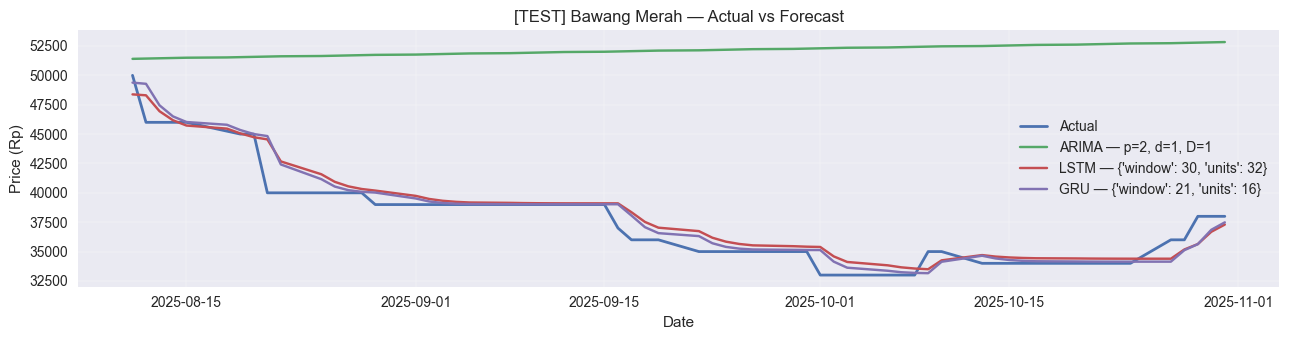

Plot Actual vs Forecast: Bawang Putih Honan


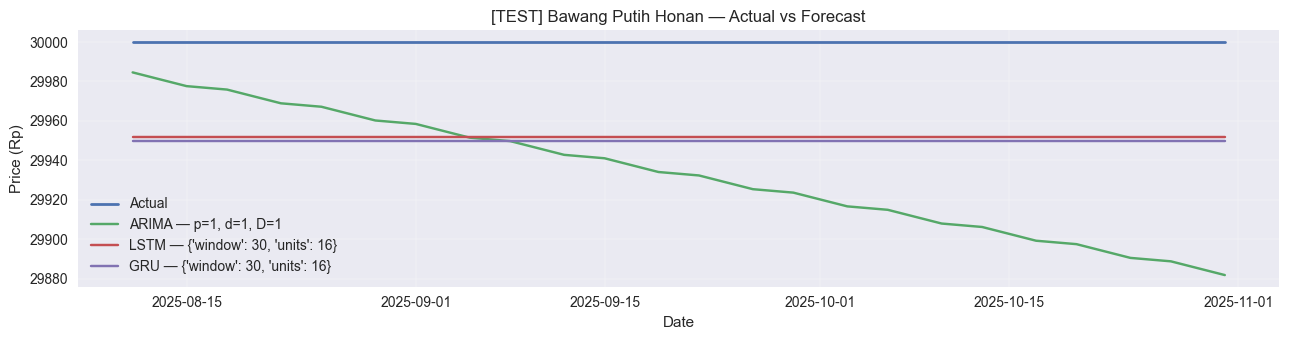

Plot Actual vs Forecast: Beras Medium


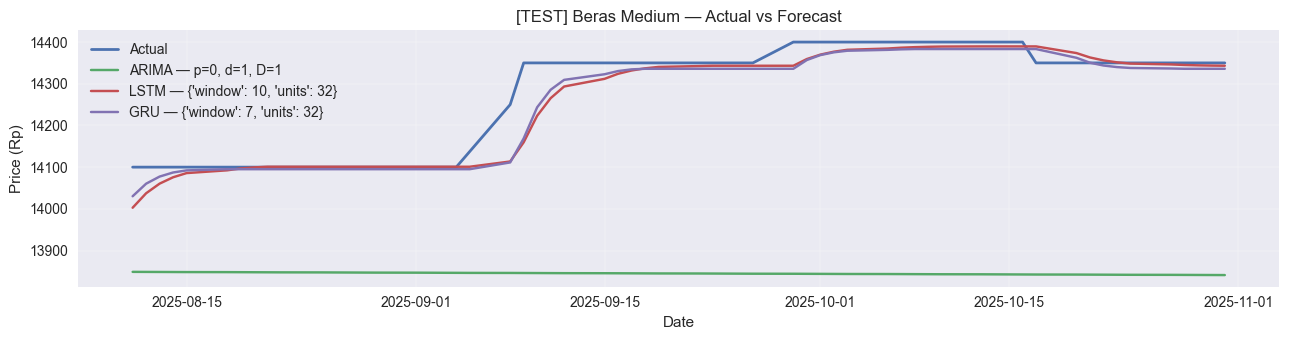

Plot Actual vs Forecast: Beras Premium


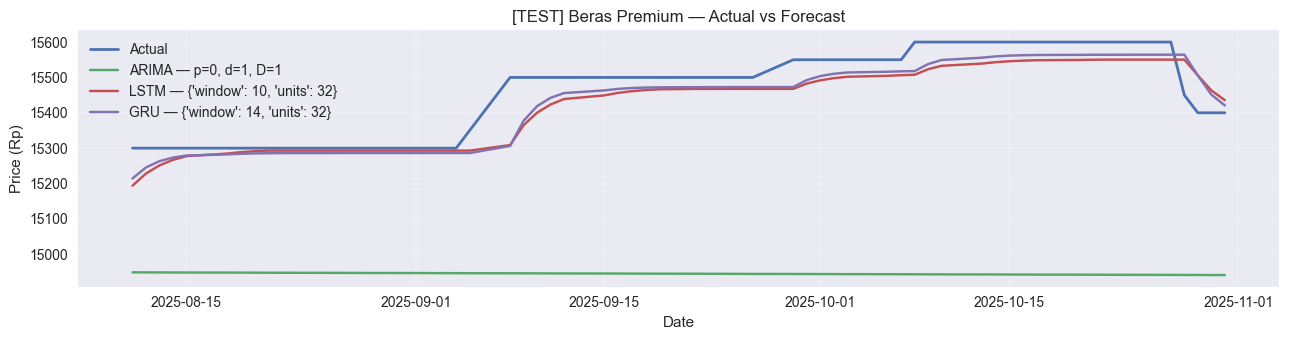

Plot Actual vs Forecast: Cabai Merah Besar


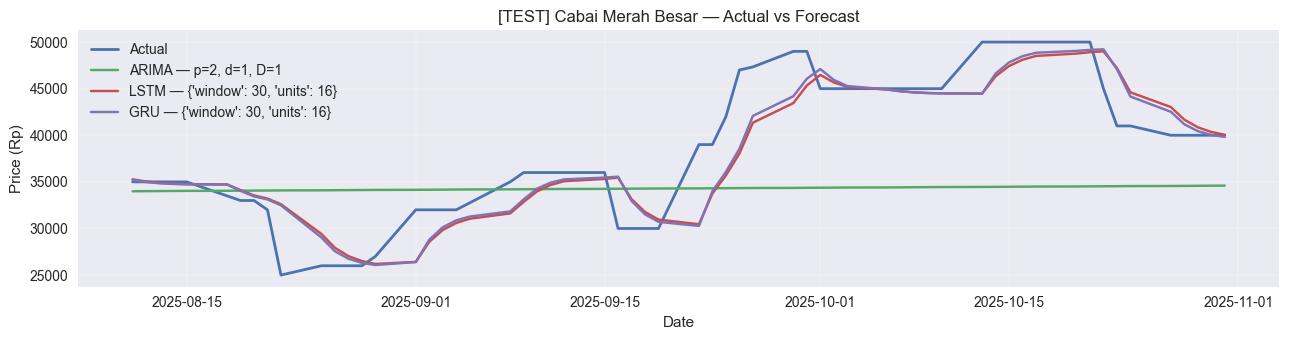

Plot Actual vs Forecast: Cabai Merah Keriting


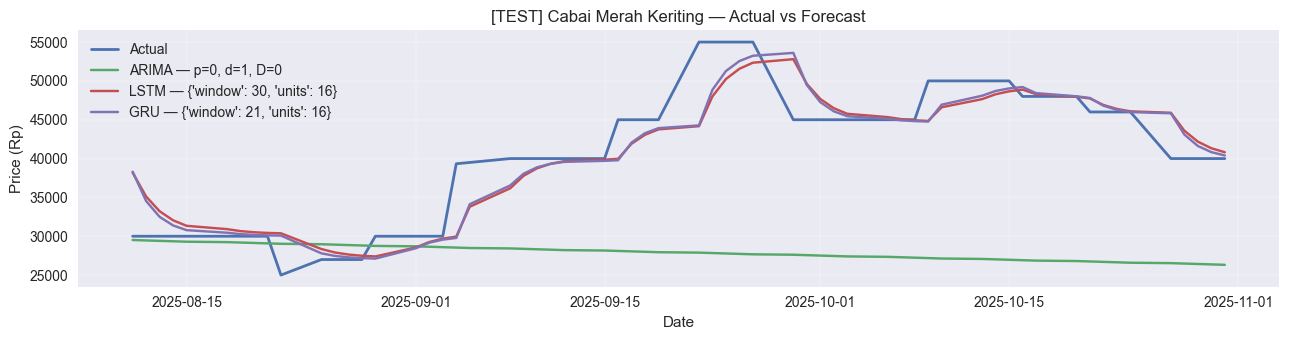

Plot Actual vs Forecast: Cabai Rawit Merah


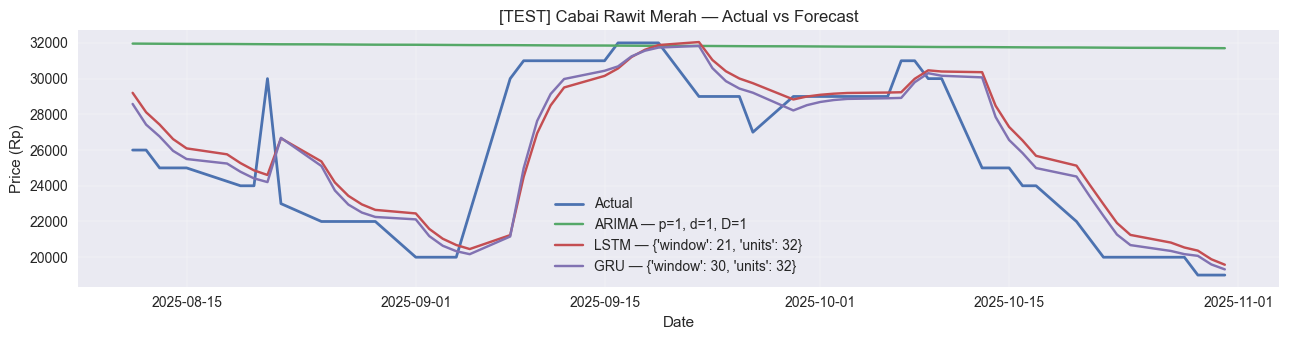

Plot Actual vs Forecast: Daging Ayam Ras


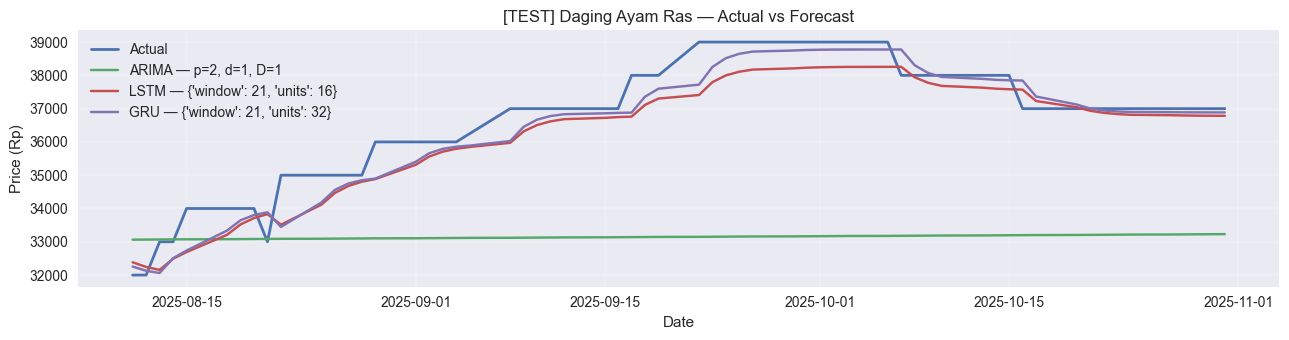

Plot Actual vs Forecast: Daging Sapi Paha Belakang


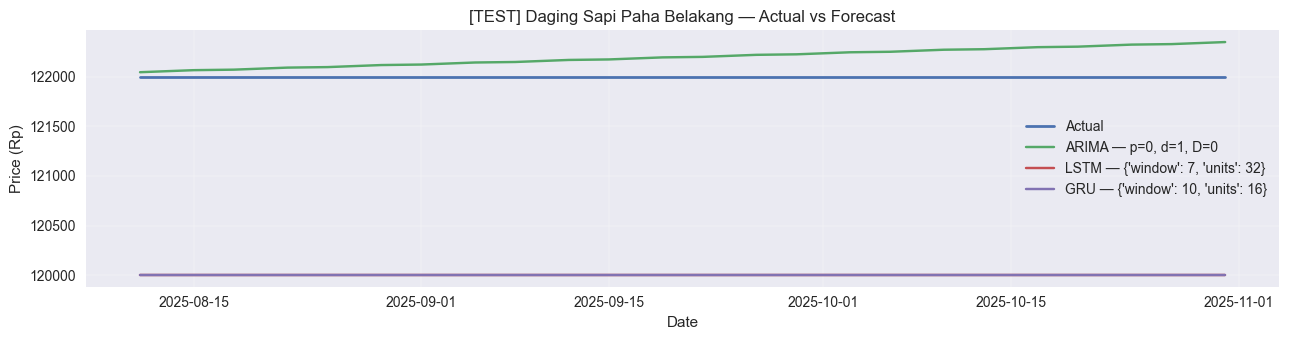

Plot Actual vs Forecast: Gula Pasir Curah


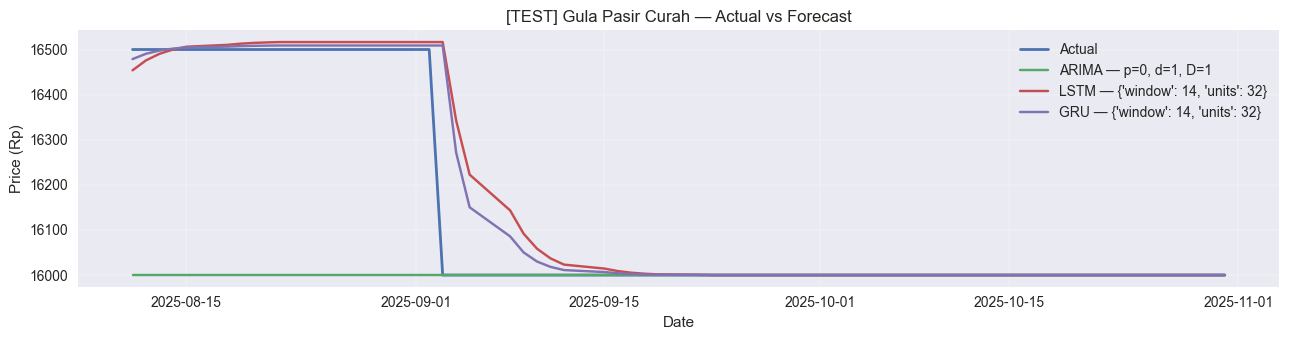

Plot Actual vs Forecast: Kedelai Impor


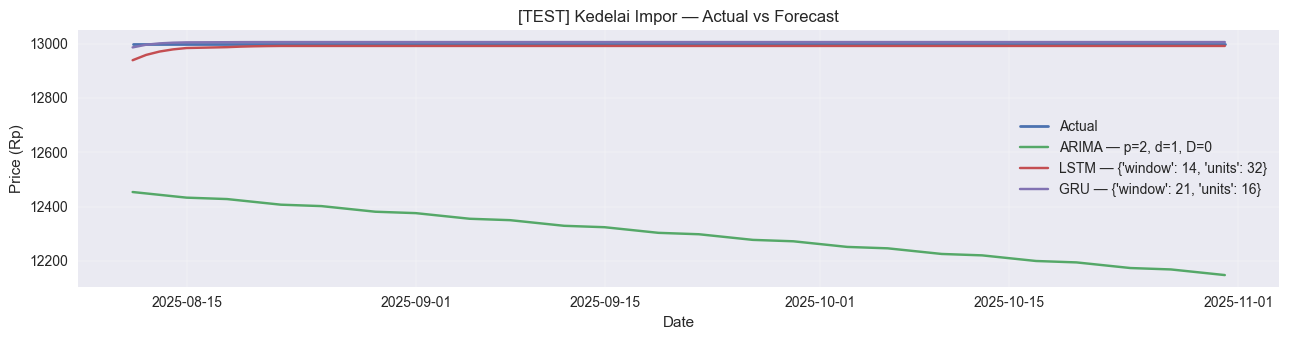

Plot Actual vs Forecast: Minyak Goreng Sawit Curah


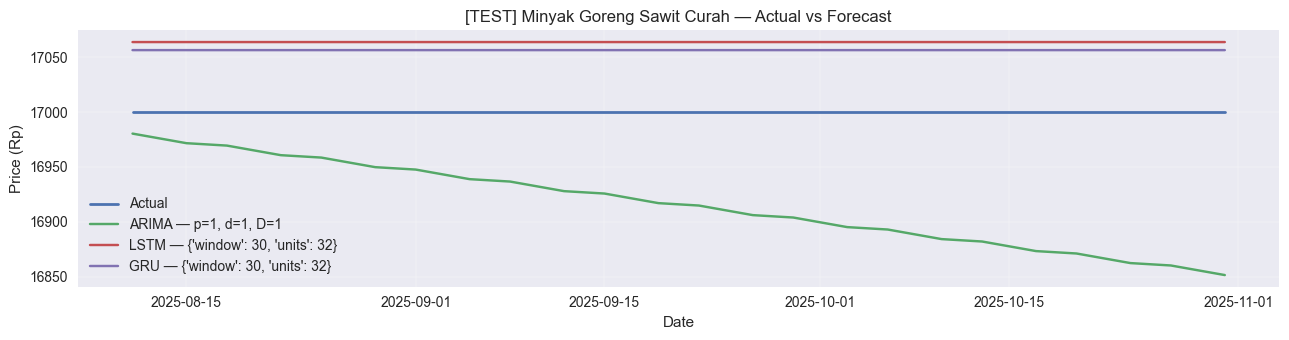

Plot Actual vs Forecast: Minyak Goreng Sawit Kemasan Premium


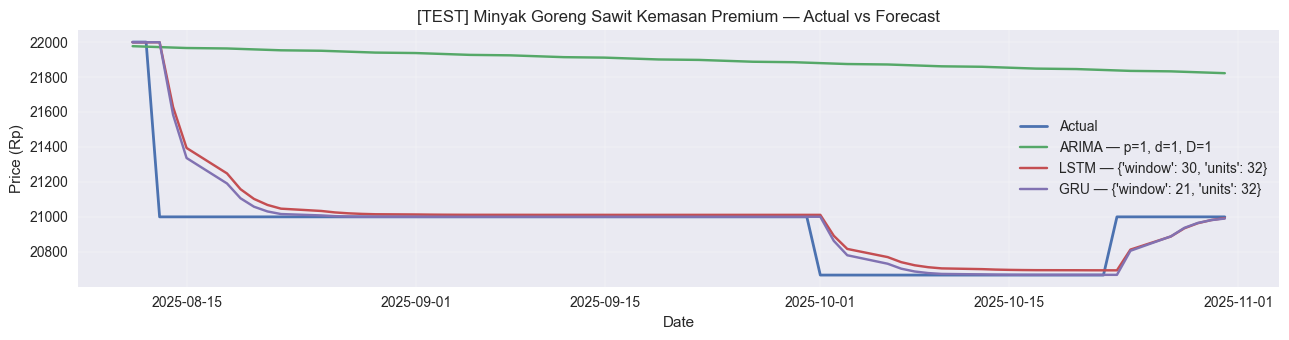

Plot Actual vs Forecast: Minyakita


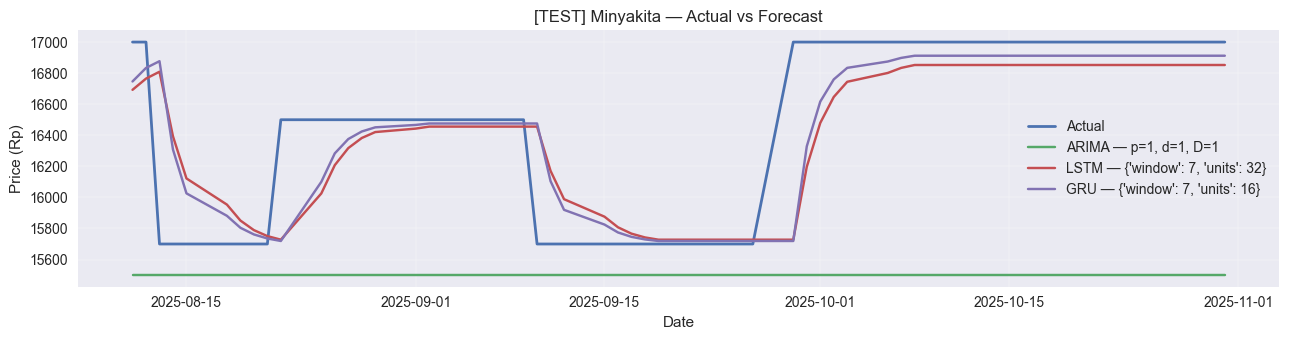

Plot Actual vs Forecast: Telur Ayam Ras


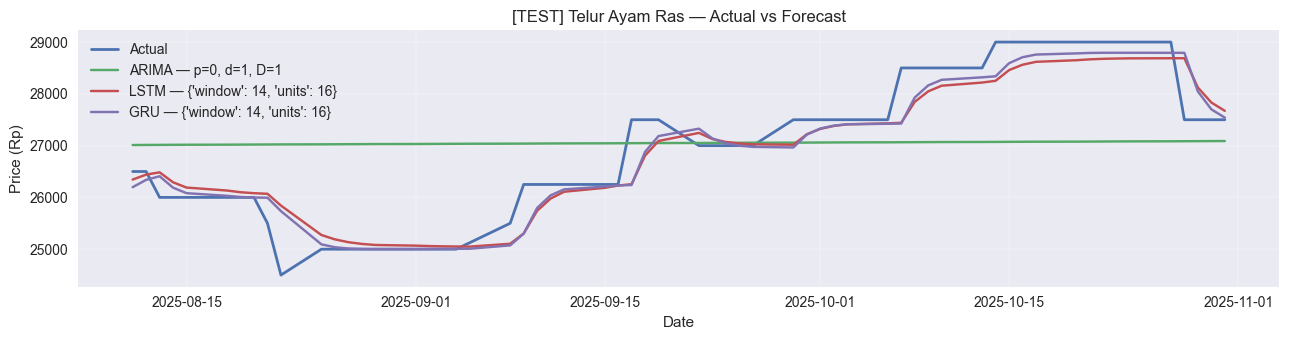

Plot Actual vs Forecast: Tepung Terigu


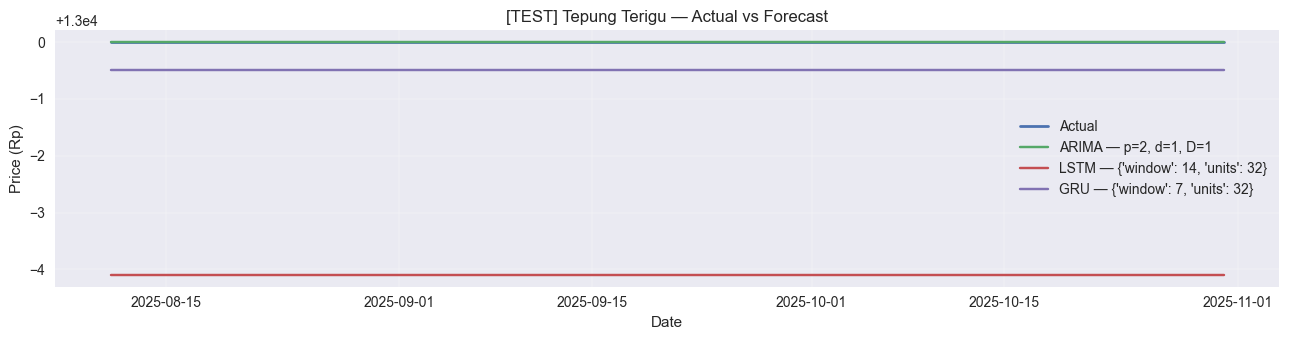

In [ ]:
def plot_actual_vs_forecast(name, dates_test, y_test, preds_dict, results_df, n_points=None):
    """
    Menampilkan grafik Actual vs Forecast untuk satu komoditas,
    dengan style:
    - judul: [TEST] {komoditas} — Actual vs Forecast
    - x-axis: tanggal
    - y-axis: Price (Rp)
    - legend: Actual, ARIMA — ARIMA(...), LSTM — LSTM(...), GRU — GRU(...)
    """
    if n_points is None or n_points > len(y_test):
        n_points = len(y_test)

    # ambil subset terakhir n_points
    dates_plot = dates_test[-n_points:]
    y_actual_plot = y_test[-n_points:]

    plt.figure(figsize=(13, 3.5))
    plt.plot(dates_plot, y_actual_plot, label="Actual", linewidth=2)

    # ambil config dari results_df untuk legend
    sub = results_df[results_df["commodity"] == name]

    for model_name, y_hat in preds_dict.items():
        y_hat_plot = y_hat[-n_points:]

        # cari config model ini
        cfg_row = sub[sub["model"] == model_name]
        if len(cfg_row) > 0:
            cfg_text = cfg_row.iloc[0]["config"]
            label = f"{model_name} — {cfg_text}"
        else:
            label = model_name

        plt.plot(dates_plot, y_hat_plot, label=label)

    plt.title(f"[TEST] {name} — Actual vs Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price (Rp)")
    plt.legend()
    plt.grid(True, linewidth=0.3, alpha=0.7)
    plt.tight_layout()
    plt.show()


# CONTOH: PLOT SEMUA KOMODITAS (Actual vs Forecast)
for name in commodities:
    if name not in all_preds:
        continue  # kalau sempat diskip karena data pendek
    print(f"Plot Actual vs Forecast: {name}")
    y_test = all_preds[name]["y_test"]
    preds = all_preds[name]["preds"]
    dates_test = all_preds[name]["dates_test"]

    plot_actual_vs_forecast(
        name,
        dates_test,
        y_test,
        preds,
        results_df,
        n_points=min(60, len(y_test))  # bisa diubah sesuai selera
    )

# Cell 11 - Visualisasi Rolling MAPE

Plot Rolling MAPE: Bawang Merah


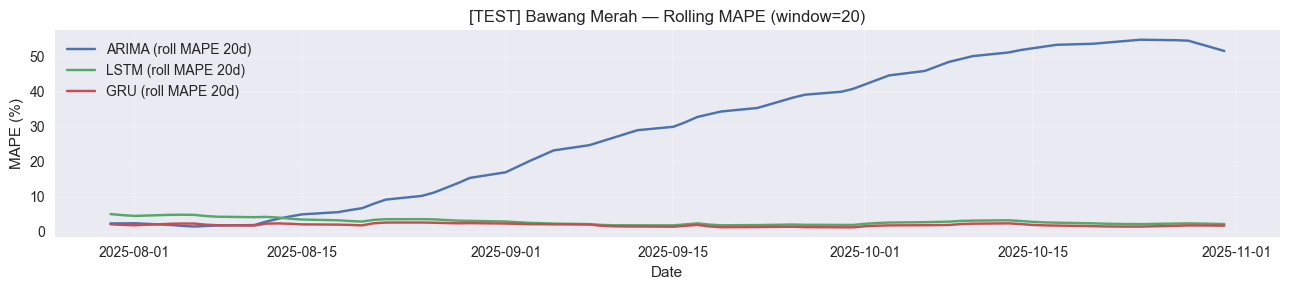

Plot Rolling MAPE: Bawang Putih Honan


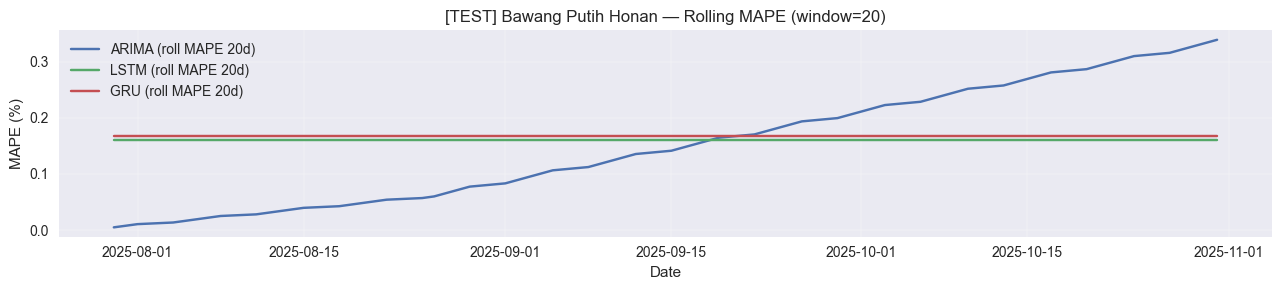

Plot Rolling MAPE: Beras Medium


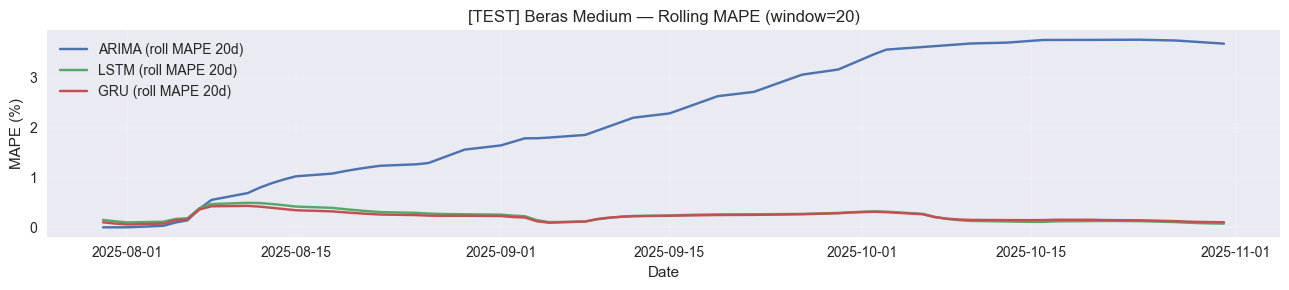

Plot Rolling MAPE: Beras Premium


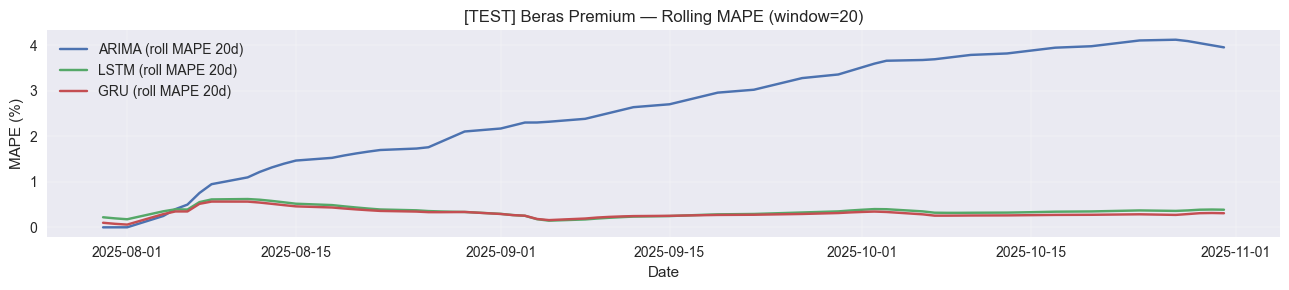

Plot Rolling MAPE: Cabai Merah Besar


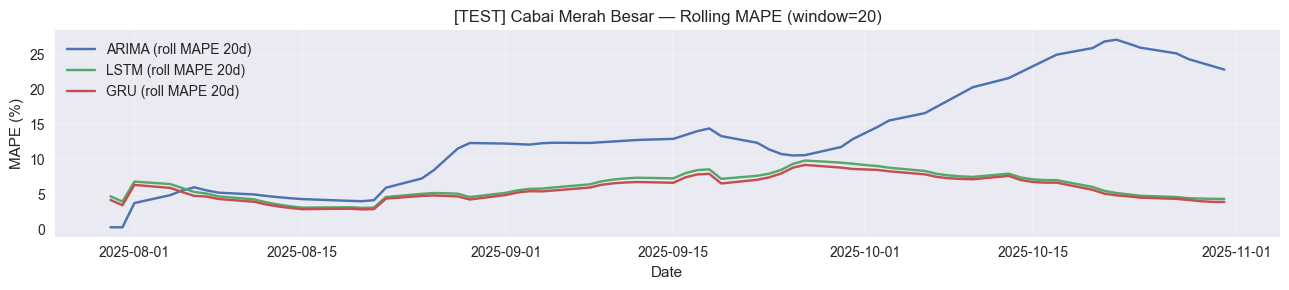

Plot Rolling MAPE: Cabai Merah Keriting


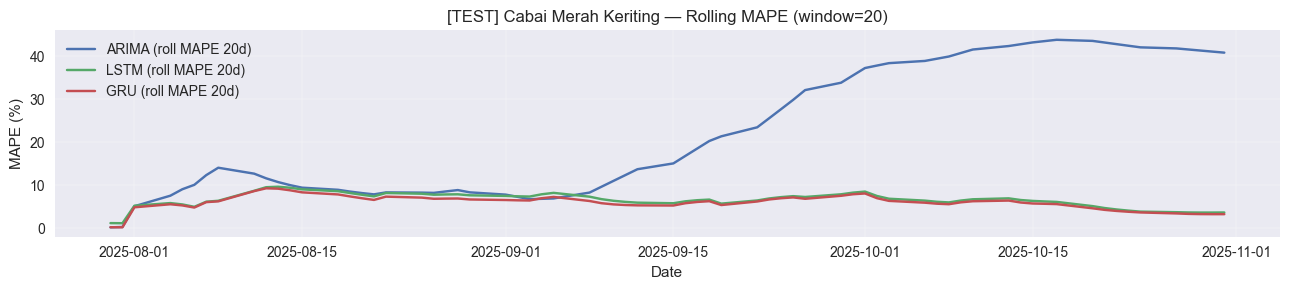

Plot Rolling MAPE: Cabai Rawit Merah


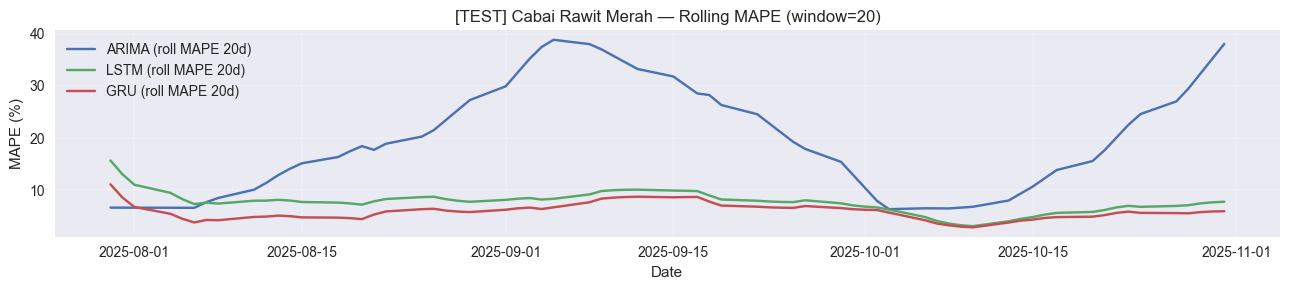

Plot Rolling MAPE: Daging Ayam Ras


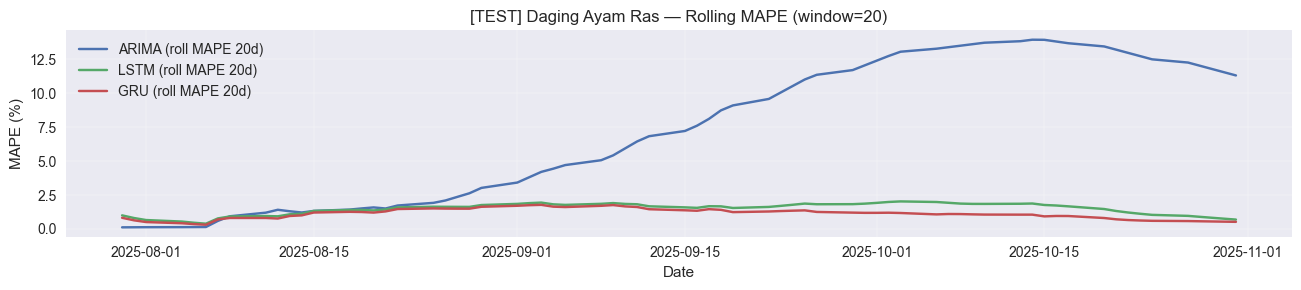

Plot Rolling MAPE: Daging Sapi Paha Belakang


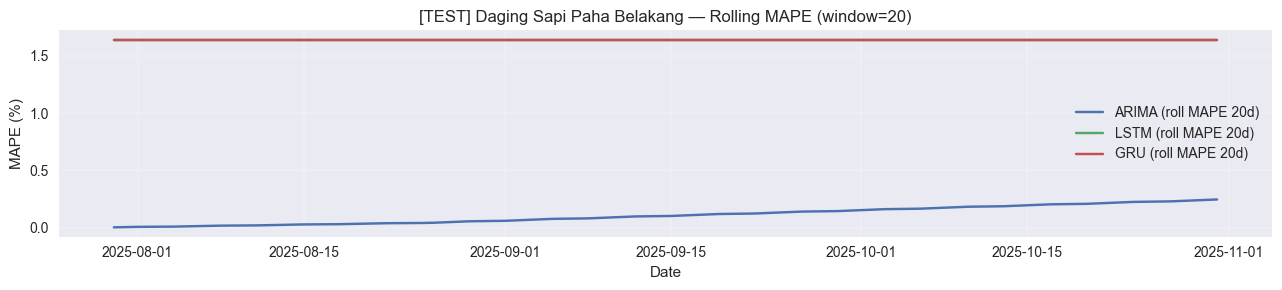

Plot Rolling MAPE: Gula Pasir Curah


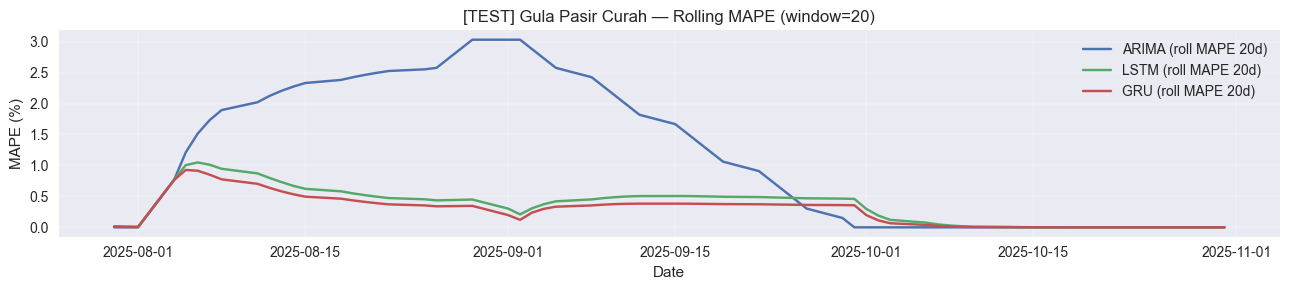

Plot Rolling MAPE: Kedelai Impor


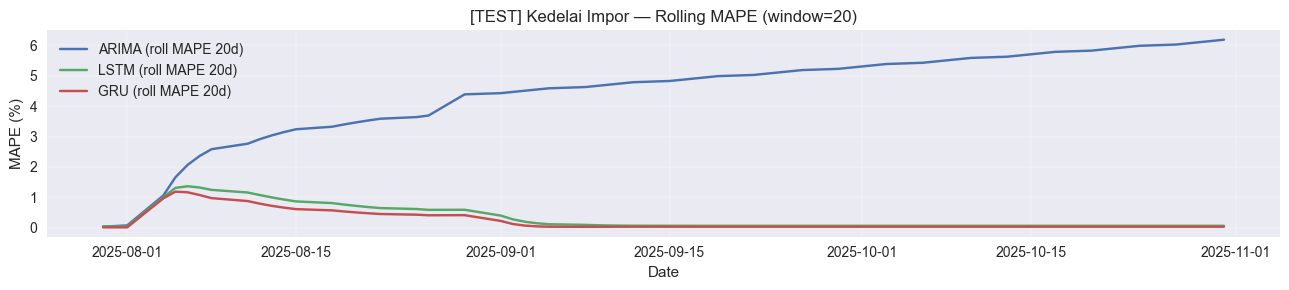

Plot Rolling MAPE: Minyak Goreng Sawit Curah


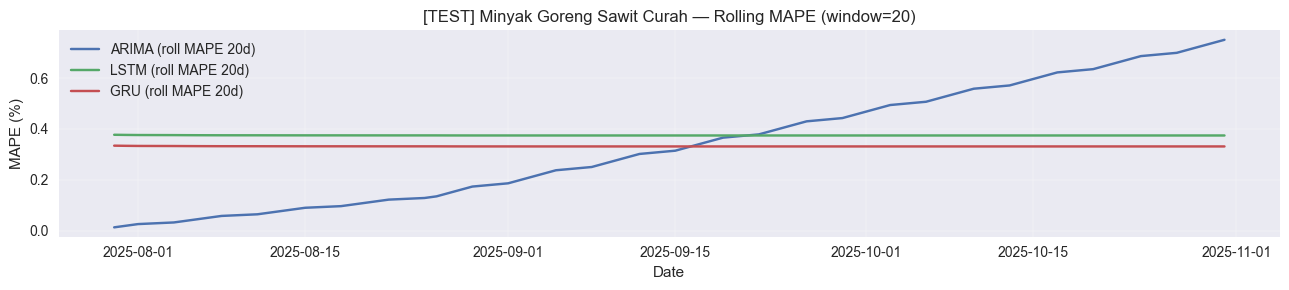

Plot Rolling MAPE: Minyak Goreng Sawit Kemasan Premium


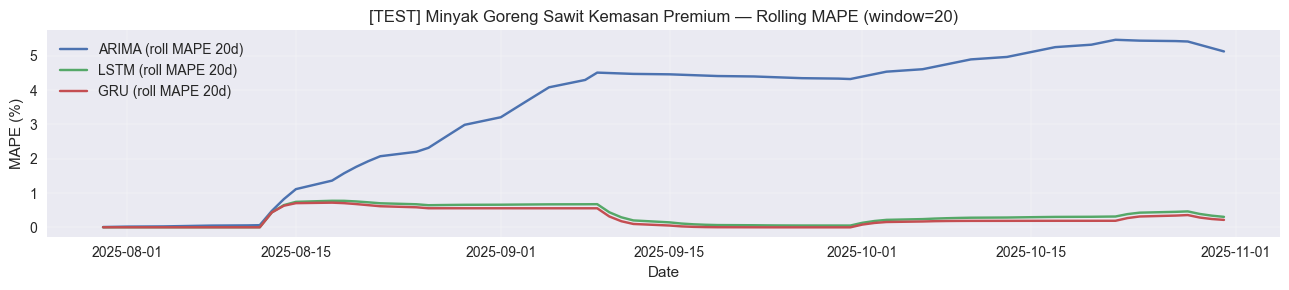

Plot Rolling MAPE: Minyakita


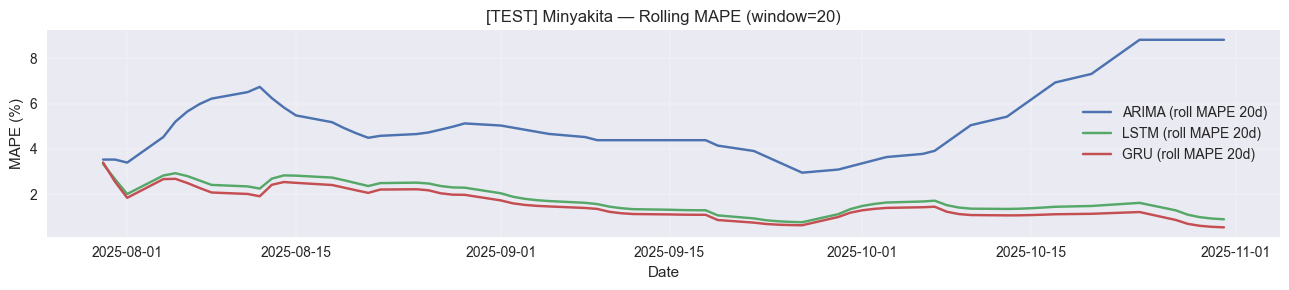

Plot Rolling MAPE: Telur Ayam Ras


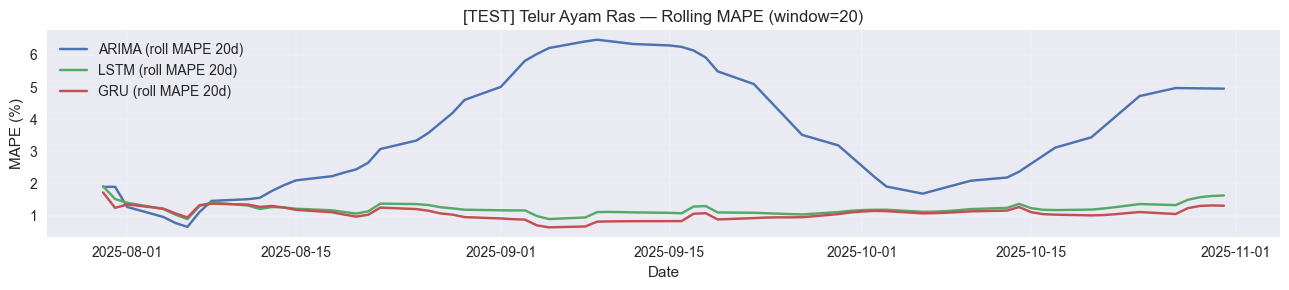

Plot Rolling MAPE: Tepung Terigu


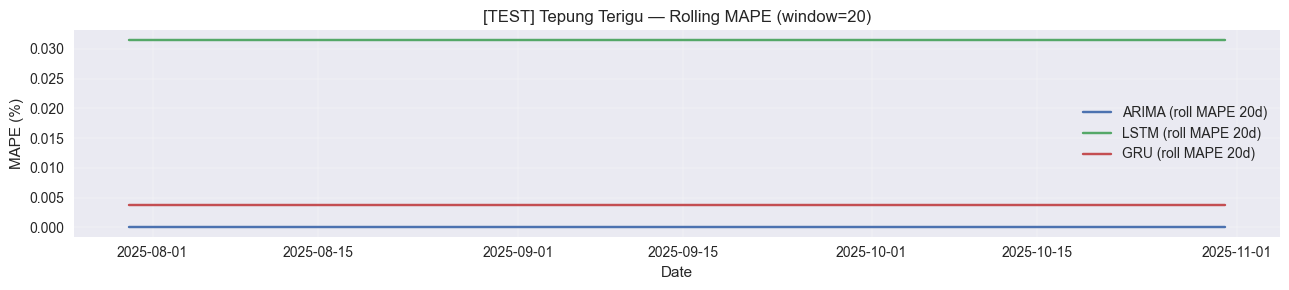

In [ ]:
# CELL 11 – PLOT ROLLING MAPE (STYLE SEPERTI CONTOH)

def plot_rolling_mape(name, dates_test, y_test, preds_dict, window=20):
    """
    Menampilkan grafik Rolling MAPE per model:
    - judul: [TEST] {komoditas} — Rolling MAPE (window=20)
    - x-axis: tanggal
    - y-axis: MAPE (%)
    - legend: ARIMA (roll MAPE 20d), dst.
    """
    plt.figure(figsize=(13, 3.0))

    for model_name, y_hat in preds_dict.items():
        series_mape = []
        for i in range(len(y_test)):
            start = max(0, i - window + 1)
            m = mape(y_test[start:i+1], y_hat[start:i+1])
            series_mape.append(m)

        label = f"{model_name} (roll MAPE {window}d)"
        plt.plot(dates_test, series_mape, label=label)

    plt.title(f"[TEST] {name} — Rolling MAPE (window={window})")
    plt.xlabel("Date")
    plt.ylabel("MAPE (%)")
    plt.legend()
    plt.grid(True, linewidth=0.3, alpha=0.7)
    plt.tight_layout()
    plt.show()


# CONTOH: PLOT ROLLING MAPE UNTUK SEMUA KOMODITAS
for name in commodities:
    if name not in all_preds:
        continue
    print(f"Plot Rolling MAPE: {name}")
    y_test = all_preds[name]["y_test"]
    preds = all_preds[name]["preds"]
    dates_test = all_preds[name]["dates_test"]

    plot_rolling_mape(
        name,
        dates_test,
        y_test,
        preds,
        window=20
    )


# Cell 12 - Forecast 30 Hari ke Depan

In [ ]:
HORIZON = 30  # jumlah hari ke depan yang ingin di-forecast

# pastikan kita sudah punya results_best_per_commodity_daily_final.csv
best_df = pd.read_csv("results_best_per_commodity_daily_final.csv")

def parse_arima_cfg(cfg_str):
    """
    Mengubah string 'p=2, d=1, D=1' menjadi (2, 1, 1)
    """
    cfg_str = str(cfg_str).replace(" ", "")
    parts = cfg_str.split(",")
    vals = {}
    for part in parts:
        if "=" in part:
            k, v = part.split("=")
            vals[k] = int(v)
    return vals.get("p", 0), vals.get("d", 0), vals.get("D", 0)


def train_lstm_full_series(y_full, window, units, epochs=EPOCHS_MAX, lr=LR):
    """
    Melatih LSTM1D pada seluruh data historis komoditas (tanpa val terpisah).
    """
    y_full = np.asarray(y_full, dtype=float)
    y_scaled, scaler = scale_series_train_only(y_full)

    X, Y = make_supervised(y_scaled, window)
    model = LSTM1D(hidden=units, lr=lr, clip=1.0)

    for epoch in range(epochs):
        for i in range(len(Y)):
            x_seq = X[i, :, 0]
            model.fit_one(x_seq, Y[i])
    return model, scaler


def forecast_lstm(model, scaler, y_full, window, horizon):
    """
    Melakukan recursive forecasting LSTM untuk horizon ke depan.
    """
    y_full = np.asarray(y_full, dtype=float)
    y_scaled = (y_full - scaler["min"]) / (scaler["max"] - scaler["min"] + 1e-8)

    history = list(y_scaled)
    preds_scaled = []

    for step in range(horizon):
        window_seq = np.array(history[-window:])
        yhat_scaled, _ = model.forward(window_seq)
        preds_scaled.append(yhat_scaled)
        history.append(yhat_scaled)

    preds_scaled = np.array(preds_scaled)
    preds = inverse_scale(preds_scaled, scaler)
    return preds


def train_gru_full_series(y_full, window, units, epochs=EPOCHS_MAX, lr=LR):
    """
    Melatih GRU1D pada seluruh data historis.
    """
    y_full = np.asarray(y_full, dtype=float)
    y_scaled, scaler = scale_series_train_only(y_full)

    X, Y = make_supervised(y_scaled, window)
    model = GRU1D(hidden=units, lr=lr, clip=1.0)

    for epoch in range(epochs):
        for i in range(len(Y)):
            x_seq = X[i, :, 0]
            model.fit_one(x_seq, Y[i])
    return model, scaler


def forecast_gru(model, scaler, y_full, window, horizon):
    """
    Melakukan recursive forecasting GRU untuk horizon ke depan.
    """
    y_full = np.asarray(y_full, dtype=float)
    y_scaled = (y_full - scaler["min"]) / (scaler["max"] - scaler["min"] + 1e-8)

    history = list(y_scaled)
    preds_scaled = []

    for step in range(horizon):
        window_seq = np.array(history[-window:])
        yhat_scaled, _ = model.forward(window_seq)
        preds_scaled.append(yhat_scaled)
        history.append(yhat_scaled)

    preds_scaled = np.array(preds_scaled)
    preds = inverse_scale(preds_scaled, scaler)
    return preds


forecast_rows = []

for _, row in best_df.iterrows():
    commodity = row["commodity"]
    best_model_name = row["model"]
    cfg_str = row["config"]

    series_full = df[commodity].dropna()
    y_full = series_full.values
    last_date = series_full.index[-1]
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                                 periods=HORIZON, freq="D")

    print(f"\n=== Forecast {commodity} dengan model terbaik: {best_model_name} ===")

    if best_model_name == "ARIMA":
        p_best, d_best, D_best = parse_arima_cfg(cfg_str)
        y_forecast = arima_pd0_predict(y_full, HORIZON,
                                       p=p_best, d=d_best, D=D_best, s=5)

    elif best_model_name == "LSTM":
        # config disimpan sebagai string dict, misal "{'window': 30, 'units': 16}"
        cfg = ast.literal_eval(cfg_str)
        w = int(cfg["window"])
        units = int(cfg["units"])

        lstm_model, scaler = train_lstm_full_series(y_full, w, units,
                                                    epochs=EPOCHS_MAX, lr=LR)
        y_forecast = forecast_lstm(lstm_model, scaler, y_full, w, HORIZON)

    elif best_model_name == "GRU":
        cfg = ast.literal_eval(cfg_str)
        w = int(cfg["window"])
        units = int(cfg["units"])

        gru_model, scaler = train_gru_full_series(y_full, w, units,
                                                  epochs=EPOCHS_MAX, lr=LR)
        y_forecast = forecast_gru(gru_model, scaler, y_full, w, HORIZON)
    else:
        # fallback (harusnya tidak terjadi)
        print(f"  Model {best_model_name} tidak dikenali, skip.")
        continue

    for d, yhat in zip(future_dates, y_forecast):
        forecast_rows.append({
            "commodity": commodity,
            "model": best_model_name,
            "date": d,
            "forecast_price": float(yhat)
        })

# gabungkan semua hasil forecast
forecast_df = pd.DataFrame(forecast_rows)
forecast_df.to_csv("forecast_next30_best_model_per_commodity.csv", index=False)
forecast_df.head()


=== Forecast Bawang Merah dengan model terbaik: GRU ===


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\523440397.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=== Forecast Bawang Putih Honan dengan model terbaik: LSTM ===


C:\Users\arthur_k\AppData\Local\Temp\ipykernel_45248\3155123925.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat = float(self.Wy @ hs[-1])



=== Forecast Beras Medium dengan model terbaik: GRU ===

=== Forecast Beras Premium dengan model terbaik: GRU ===

=== Forecast Cabai Merah Besar dengan model terbaik: GRU ===

=== Forecast Cabai Merah Keriting dengan model terbaik: GRU ===

=== Forecast Cabai Rawit Merah dengan model terbaik: GRU ===

=== Forecast Daging Ayam Ras dengan model terbaik: GRU ===

=== Forecast Daging Sapi Paha Belakang dengan model terbaik: ARIMA ===

=== Forecast Gula Pasir Curah dengan model terbaik: GRU ===

=== Forecast Kedelai Impor dengan model terbaik: GRU ===

=== Forecast Minyak Goreng Sawit Curah dengan model terbaik: GRU ===

=== Forecast Minyak Goreng Sawit Kemasan Premium dengan model terbaik: GRU ===

=== Forecast Minyakita dengan model terbaik: GRU ===

=== Forecast Telur Ayam Ras dengan model terbaik: GRU ===

=== Forecast Tepung Terigu dengan model terbaik: ARIMA ===


,commodity,model,date,forecast_price
0,Bawang Merah,GRU,2025-11-01,37586.654212
1,Bawang Merah,GRU,2025-11-02,37600.889479
2,Bawang Merah,GRU,2025-11-03,37612.422229
3,Bawang Merah,GRU,2025-11-04,37622.885861
4,Bawang Merah,GRU,2025-11-05,37632.936810


# Cell 13 - Plot Actual + Forecast 30 Hari

Plot history + forecast: Bawang Merah


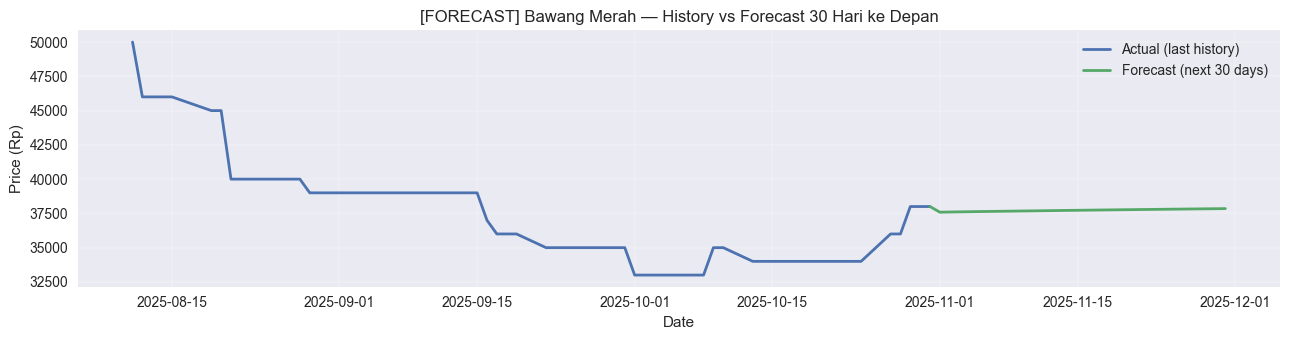

Plot history + forecast: Bawang Putih Honan


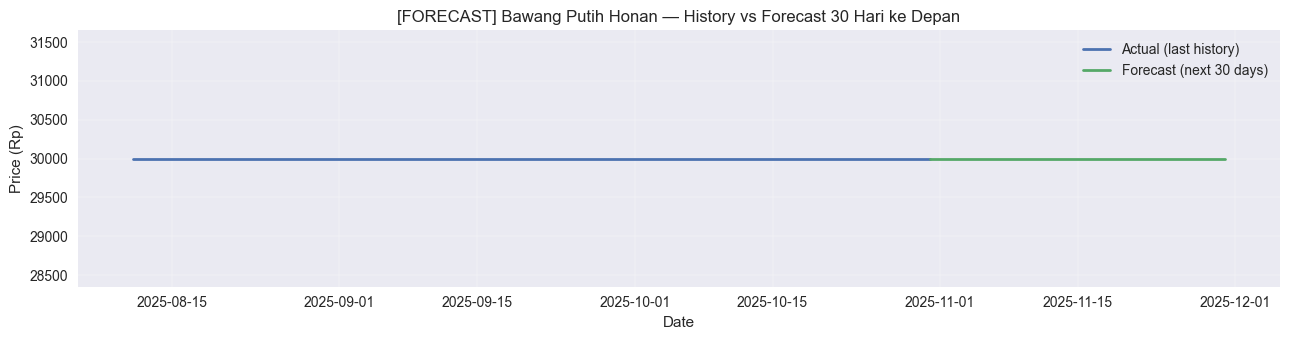

Plot history + forecast: Beras Medium


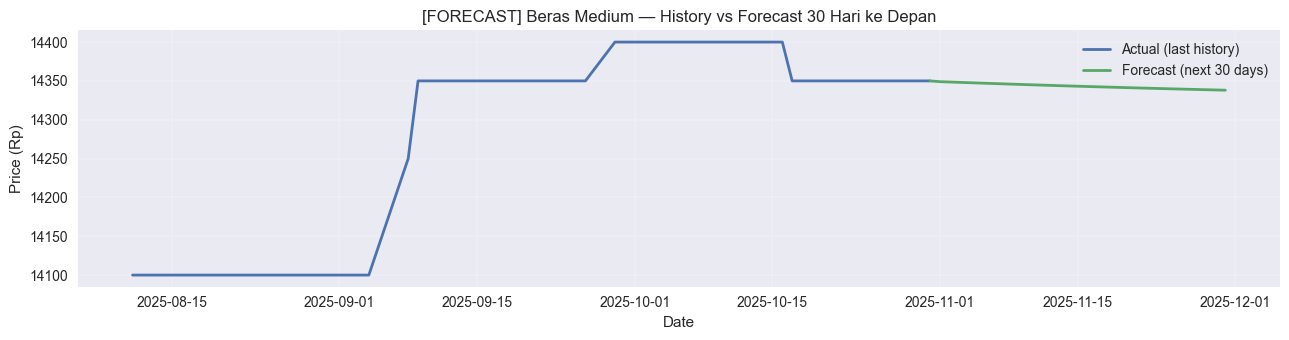

Plot history + forecast: Beras Premium


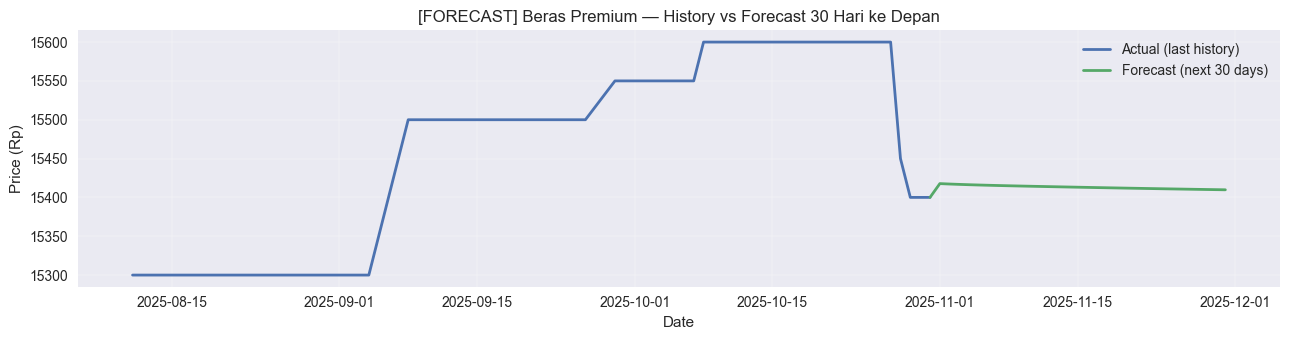

Plot history + forecast: Cabai Merah Besar


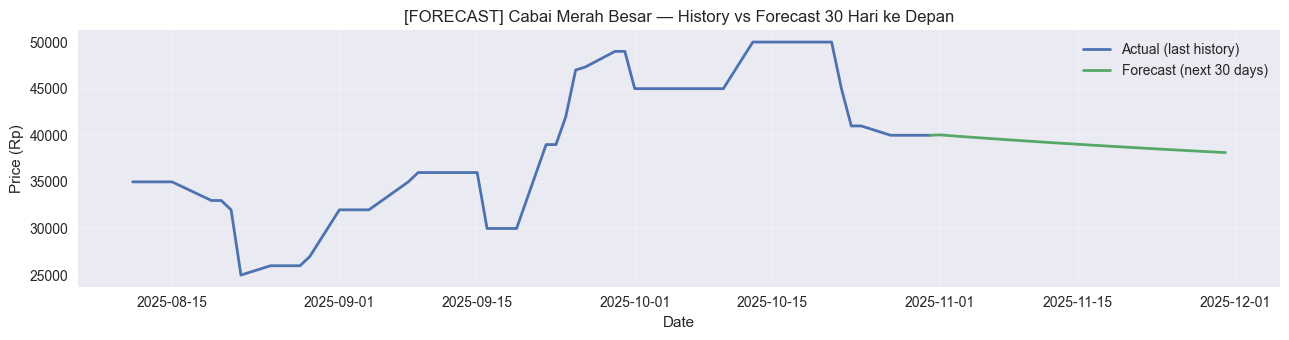

Plot history + forecast: Cabai Merah Keriting


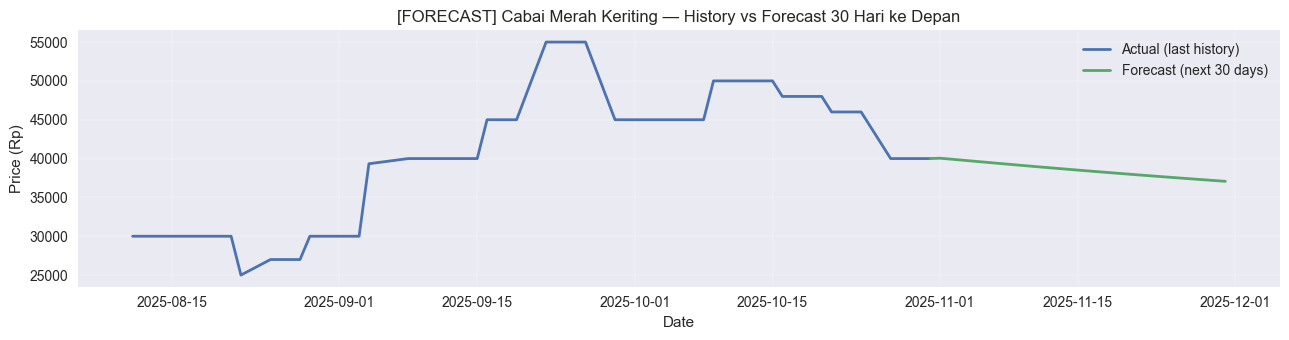

Plot history + forecast: Cabai Rawit Merah


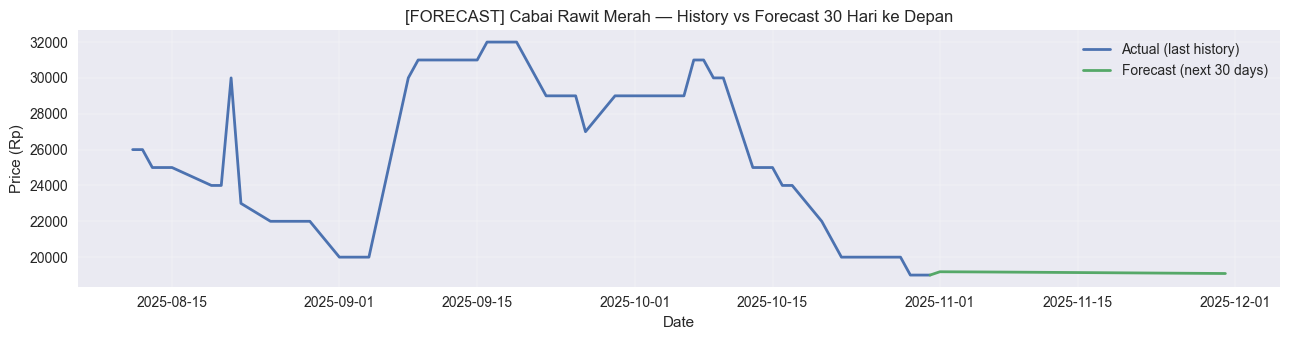

Plot history + forecast: Daging Ayam Ras


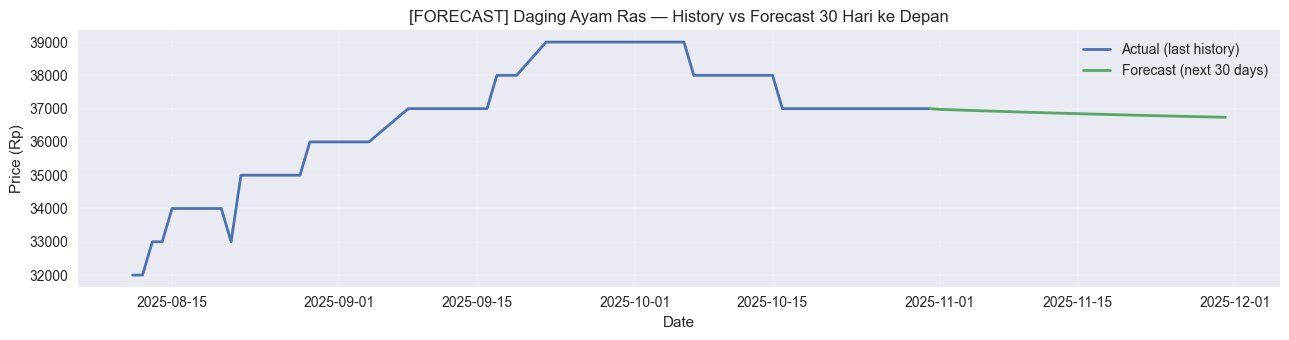

Plot history + forecast: Daging Sapi Paha Belakang


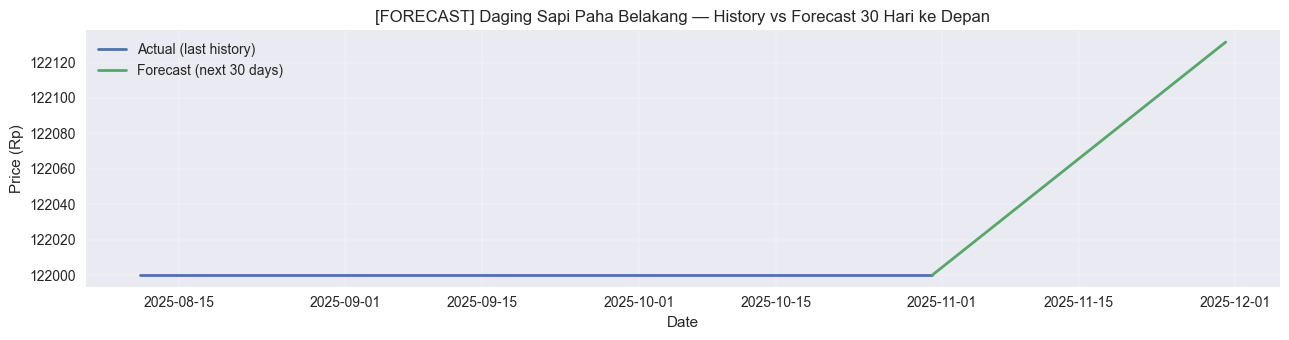

Plot history + forecast: Gula Pasir Curah


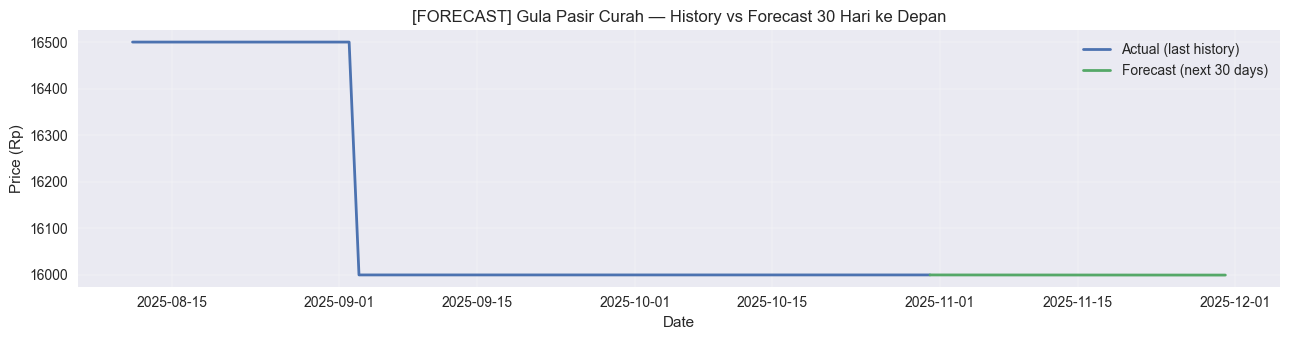

Plot history + forecast: Kedelai Impor


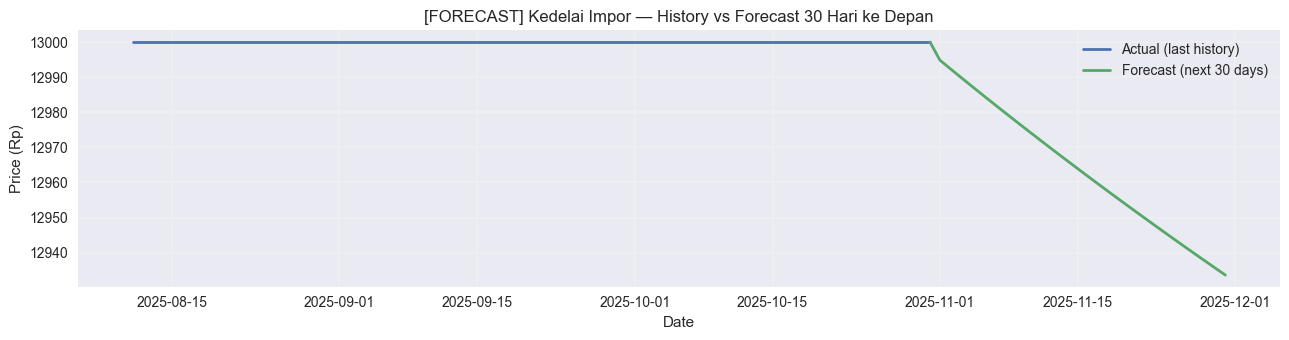

Plot history + forecast: Minyak Goreng Sawit Curah


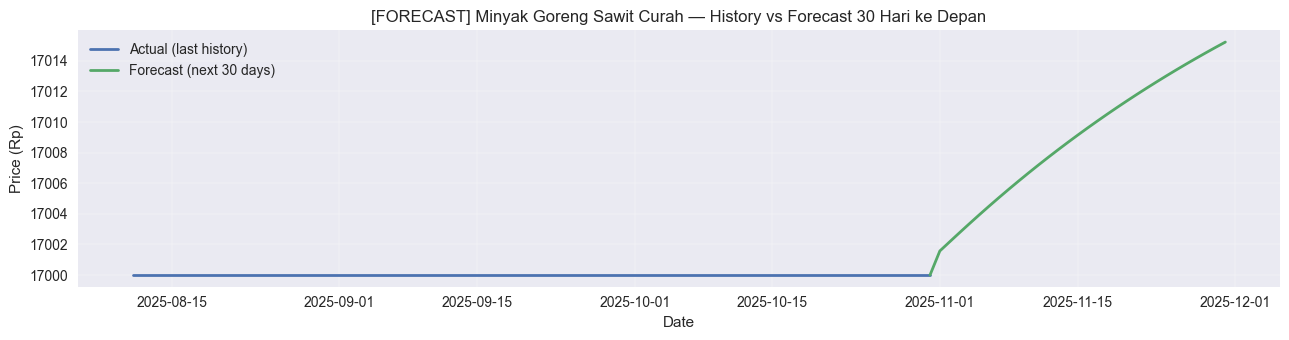

Plot history + forecast: Minyak Goreng Sawit Kemasan Premium


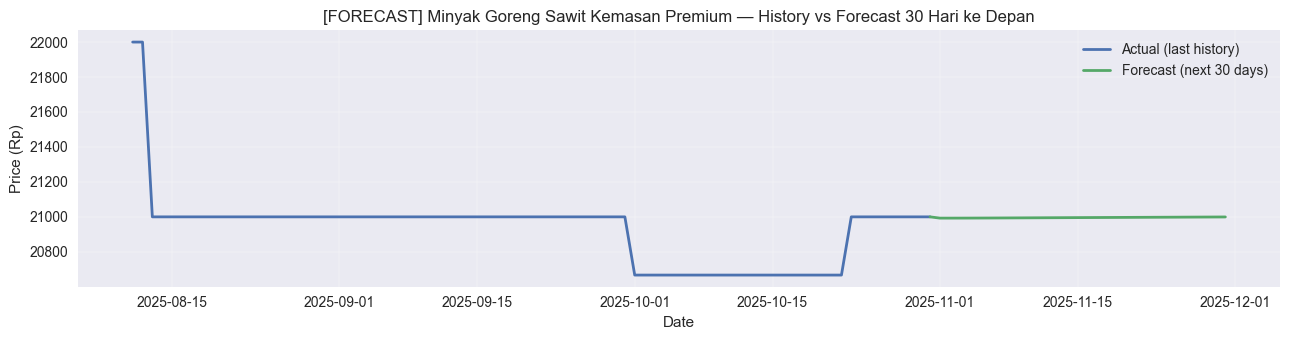

Plot history + forecast: Minyakita


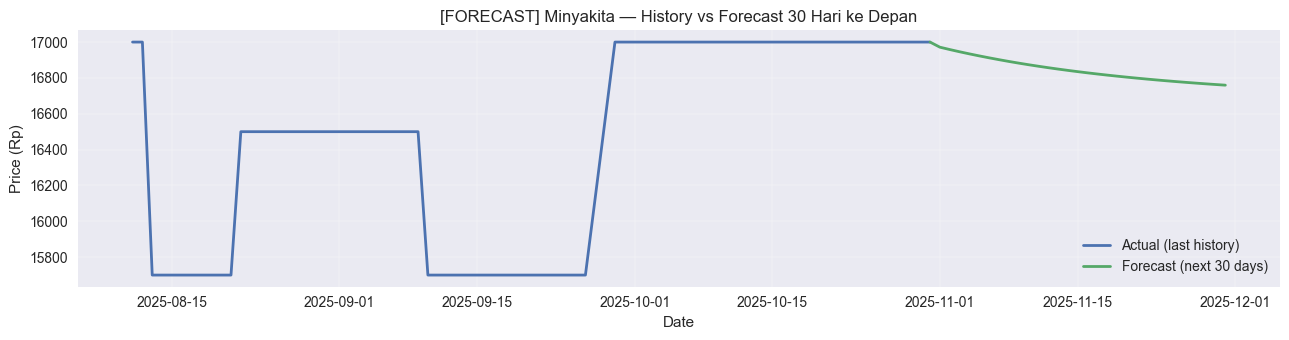

Plot history + forecast: Telur Ayam Ras


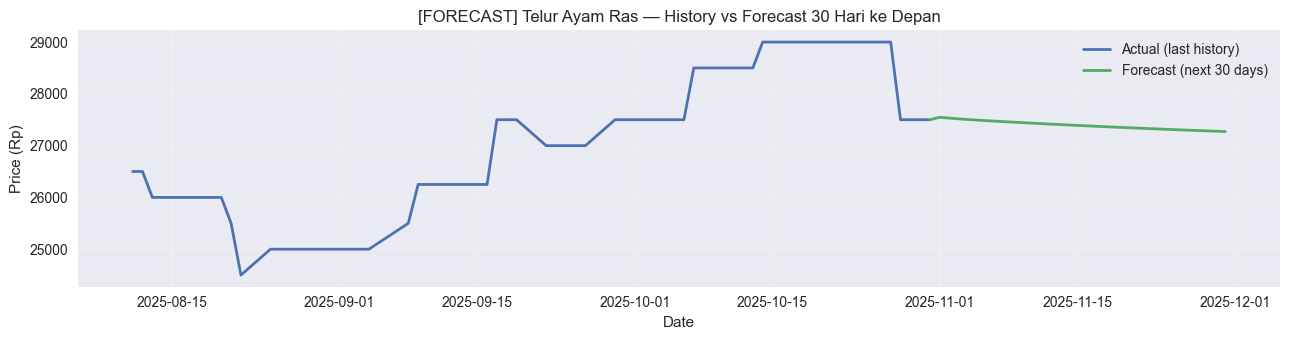

Plot history + forecast: Tepung Terigu


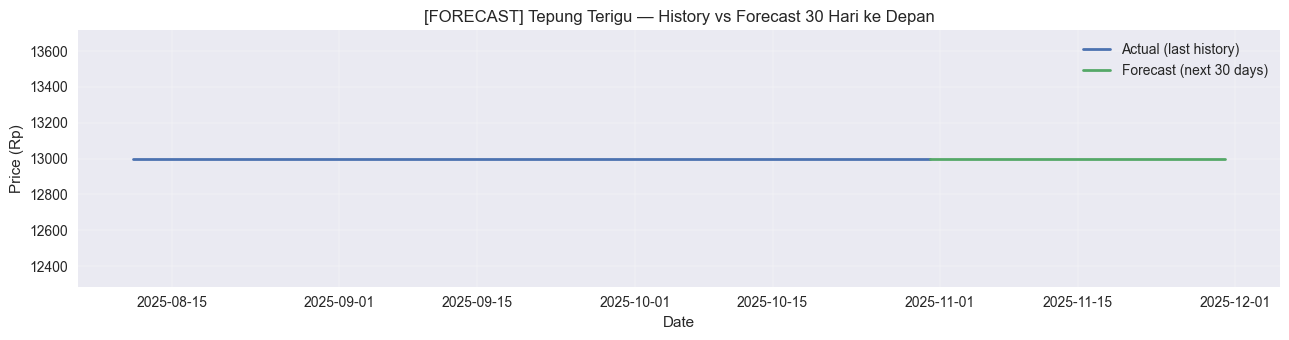

In [ ]:
# kalau forecast_df belum ada di memory (misal baru load notebook), load dulu
try:
    forecast_df
except NameError:
    forecast_df = pd.read_csv("forecast_next30_best_model_per_commodity.csv",
                              parse_dates=["date"])

hist_len = 60  # banyak hari historis terakhir yang mau ditampilkan sebelum forecast

commodities_forecast = forecast_df["commodity"].unique().tolist()

for name in commodities:
    if name not in commodities_forecast:
        print(f"Skip {name} (tidak ada di forecast_df)")
        continue

    print(f"Plot history + forecast: {name}")

    # ambil seri historis lengkap dari df
    series_full = df[name].dropna()
    y_full = series_full.values
    dates_full = series_full.index

    # ambil history terakhir
    y_hist_plot = y_full[-hist_len:]
    dates_hist_plot = dates_full[-hist_len:]

    # ambil forecast 30 hari dari forecast_df
    sub_fc = forecast_df[forecast_df["commodity"] == name].sort_values("date")
    dates_fc = sub_fc["date"].values
    y_fc = sub_fc["forecast_price"].values

    # plot
    plt.figure(figsize=(13, 3.5))
    # plt.plot(dates_hist_plot, y_hist_plot,
    #          label="Actual (last history)", linewidth=2)
    # plt.plot(dates_fc, y_fc,
    #          label="Forecast (next 30 days)", linewidth=2)

    # titik terakhir history
    last_actual_date = dates_hist_plot[-1]
    last_actual_value = y_hist_plot[-1]

    # pastikan dates_fc bertipe datetime
    dates_fc = pd.to_datetime(sub_fc["date"])

    # sambungkan garis (versi aman untuk tipe datetime)
    dates_fc_plot = pd.concat([
        pd.Series([last_actual_date]),
        dates_fc.reset_index(drop=True)
    ], ignore_index=True)

    y_fc_plot = np.concatenate([[last_actual_value], y_fc])

    plt.plot(dates_hist_plot, y_hist_plot, label="Actual (last history)", linewidth=2)
    plt.plot(dates_fc_plot, y_fc_plot, label="Forecast (next 30 days)", linewidth=2)

    plt.title(f"[FORECAST] {name} — History vs Forecast 30 Hari ke Depan")
    plt.xlabel("Date")
    plt.ylabel("Price (Rp)")
    plt.legend()
    plt.grid(True, linewidth=0.3, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
# !jupyter nbconvert --to script modeling_daily_newest.ipynb

[NbConvertApp] Converting notebook modeling_daily_newest.ipynb to script
[NbConvertApp] Writing 32234 bytes to modeling_daily_newest.py
